In [5]:
from functools import partial
import os
import argparse
import yaml
# import pandas as pd
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
from torchvision.models import inception_v3
from util.img_utils import Blurkernel#, ifft2_m,fft2_m
from guided_diffusion.fastmri_utils import fft2c_new,ifft2c_new
from guided_diffusion.condition_methods import get_conditioning_method
from guided_diffusion.measurements import get_noise, get_operator
from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion_correct import create_sampler
from data.dataloader import get_dataset, get_dataloader
from util.img_utils import clear_color, mask_generator
from util.logger import get_logger
from common_utils import *
from ddim_sampler import *
import shutil
import lpips
from scheduling_ddpm import DDPMScheduler
from functools import partial
import math

In [6]:
np.random.seed(41)
torch.manual_seed(41)
torch.cuda.manual_seed_all(41)
torch.backends.cudnn.deterministic = True

In [7]:
def load_yaml(file_path: str) -> dict:
    with open(file_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config

model_config='/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/configs/model_config.yaml'
diffusion_config='/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/configs/diffusion_config.yaml'
task_config= '/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/configs/phase_retrieval_config.yaml'

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# Load configurations
model_config = load_yaml(model_config)
diffusion_config = load_yaml(diffusion_config)
task_config = load_yaml(task_config)

In [8]:
model = create_model(**model_config)
model = model.to(device)


# Prepare Operator and noise
measure_config = task_config['measurement']
operator = get_operator(device=device, **measure_config['operator'])
noiser = get_noise(**measure_config['noise'])
#logger.info(f"Operation: {measure_config['operator']['name']} / Noise: {measure_config['noise']['name']}")

# Prepare conditioning method
cond_config = task_config['conditioning']
cond_method = get_conditioning_method(cond_config['method'], operator, noiser, **cond_config['params'])
measurement_cond_fn = cond_method.conditioning
#logger.info(f"Conditioning method : {task_config['conditioning']['method']}")

# Prepare dataloader
data_config = task_config['data']
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = get_dataset(**data_config, transforms=transform)
loader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)

# Exception) In case of inpainting, we need to generate a mask 
if measure_config['operator']['name'] == 'inpainting':
    mask_gen = mask_generator(
       **measure_config['mask_opt']
    )



In [9]:

scheduler = DDIMScheduler()

In [10]:
criterion = torch.nn.L1Loss().to(device)

In [11]:
losses = []
psnrs = []
out_visual = []

In [12]:
def compute_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # Assuming the image is normalized to [0, 1]
    psnr = 20 * np.log10(max_pixel / (mse**0.5))
    return psnr.item()

In [13]:
def compute_mce(reconstructed_image, measured_magnitude, target_shape=None):
    """Compute L2 error between Fourier magnitude of reconstruction and measured magnitude."""
    # Bring to [0, 1] range if needed
    x_hat = reconstructed_image.clamp(0, 1)

    # Pad to match measurement shape (e.g., 384x384)
    if target_shape is not None:
        _, _, H, W = x_hat.shape
        target_H, target_W = target_shape[-2], target_shape[-1]
        pad_h = (target_H - H) // 2
        pad_w = (target_W - W) // 2
        x_hat = F.pad(x_hat, (pad_w, pad_w, pad_h, pad_h))

    # Ensure complex
    if not torch.is_complex(x_hat):
        x_hat = x_hat.type(torch.complex64)

    # Compute FFT and error
    fft_x_hat = torch.view_as_complex(fft2c_new(torch.view_as_real(x_hat)))
    magnitude_error = (fft_x_hat.abs() - measured_magnitude).pow(2).mean()
    return magnitude_error.item()

In [14]:
def optimize_input(input,  sqrt_one_minus_alpha_cumprod, sqrt_alpha_cumprod, t,
                   num_steps=20, learning_rate=0.01):
    """
    Inner measurement-consistency optimization at diffusion step t.
    input: current x_t (no grad required)
    Returns: (x_t_new, x0_pred, noise_pred)
    """
    # treat the incoming x_t as a constant anchor for the proximity term
    input_anchor = input.detach()

    # create a fresh leaf variable to optimize
    x_t = input_anchor.clone().requires_grad_(True)
    opt = torch.optim.Adam([x_t], lr=learning_rate)

    tt = torch.full((1,), int(t), device=x_t.device, dtype=torch.long)

    x0 = None  # keep last x0 for returning
    for _ in range(num_steps):
        opt.zero_grad()

        # predict noise and x0
        noise_pred = model(x_t, tt)[:, :3]
        x0 = (x_t - sqrt_one_minus_alpha_cumprod * noise_pred) / sqrt_alpha_cumprod
        x0 = x0.clamp(-1, 1)

        # your current forward: manual FFT magnitude pipeline
        pad = int((2 / 8.0) * 256)
        x01 = (x0 * 0.5 + 0.5).clamp(0, 1)
        xpad = F.pad(x01, (pad, pad, pad, pad))
        if not torch.is_complex(xpad):
            xpad = xpad.type(torch.complex64)
        fft2_m = torch.view_as_complex(fft2c_new(torch.view_as_real(xpad)))
        out = fft2_m.abs()

        # data term + proximity (anchor is detached, so no outer graph reuse)
        loss_mc  = torch.norm(out - y_n)**2
        loss_reg = 0.1 * torch.norm(x_t - input_anchor)**2
        loss = loss_mc + loss_reg

        loss.backward()
        opt.step()

        # optional visualization – detach to avoid holding graphs
        back_y = ifft2c_new(torch.view_as_real(fft2_m.type(torch.complex64)))
        back_y = torch.view_as_complex(back_y).detach()
        # out_visual.append(back_y)

    # recover (optional) noise from final pair
    noise = (x_t - sqrt_alpha_cumprod * x0) / sqrt_one_minus_alpha_cumprod
    return x_t.detach(), x0.detach(), noise.detach()

In [15]:
# =========================
# Branching & Scoring Utils
# =========================

# -- Optional: LPIPS (already imported in your file)
# Make a lazy/global holder so we don't re-create the network each call
_LPIPS_MODEL = None
_INCEPTION = None

def get_lpips_model(device):
    global _LPIPS_MODEL
    if _LPIPS_MODEL is None:
        _LPIPS_MODEL = lpips.LPIPS(net='vgg').to(device).eval()
    return _LPIPS_MODEL

'''def get_inception(device):
    """
    Lightweight inception for FID features (pool3 ~ 2048-d). Using torchvision's inception_v3.
    We take features from the last pooling layer before classification.
    NOTE: FID is meaningful only against a dataset's (mu, Sigma). For per-image demo, we provide
    a 'proxy FID' versus a provided real reference (gt) or precomputed stats.
    """
    global _INCEPTION
    if _INCEPTION is None:
        inc = inception_v3(pretrained=True, transform_input=False, aux_logits=False)
        inc.fc = torch.nn.Identity()  # drop classifier head; output is 2048 features
        _INCEPTION = inc.to(device).eval()
    return _INCEPTION'''

from torchvision.models import inception_v3
try:
    # Newer torchvision
    from torchvision.models.inception import Inception_V3_Weights
    _INCEPTION_WEIGHTS = Inception_V3_Weights.IMAGENET1K_V1
except Exception:
    # Fallback if enum not available
    _INCEPTION_WEIGHTS = None

_INCEPTION = None

def get_inception(device):
    """
    Load InceptionV3 for FID features (pool3 ~ 2048-d).
    Uses torchvision's weights API; we *don't* override aux_logits/transform_input,
    to avoid the ValueError you saw.
    """
    global _INCEPTION
    if _INCEPTION is None:
        if _INCEPTION_WEIGHTS is not None:
            # Let weights decide aux_logits & transform_input
            inc = inception_v3(weights=_INCEPTION_WEIGHTS)
        else:
            # Very old torchvision: fall back to pretrained=True
            inc = inception_v3(pretrained=True)

        # Drop classifier head → we only want features
        inc.fc = nn.Identity()

        # Aux logits are only used in training mode; we're in eval() anyway.
        # No need to delete, but we *could* do:
        # if hasattr(inc, "AuxLogits"):
        #     inc.AuxLogits = nn.Identity()

        inc = inc.to(device).eval()
        _INCEPTION = inc
    return _INCEPTION


@torch.no_grad()
def _inception_acts(img_bchw_01, device):
    """
    img_bchw_01: float tensor in [0,1], Bx3xHxW (H,W >= 75 preferred)
    returns: Bx2048 features
    """
    inc = get_inception(device)
    # InceptionV3 expects roughly [-1,1]
    x = img_bchw_01 # * 2 - 1
    # Resize to 299 if needed
    if x.shape[-1] != 299 or x.shape[-2] != 299:
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
    feats = inc(x)
    
    # if isinstance(feats, (tuple, list)):
        # feats = feats[0]
        
    return feats

def compute_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Classic FID formula between two Gaussians N(mu1, Sigma1) and N(mu2, Sigma2).
    For per-image 'proxy FID', you can set (mu1,sigma1) to the candidate's single-vector stats
    and (mu2,sigma2) to a real reference (e.g., dataset stats). This is only a demo proxy.
    """
    diff = mu1 - mu2
    # product might be not PSD numerically; add eps
    covmean = torch.linalg.sqrtm((sigma1 @ sigma2).cpu().double()).real.to(sigma1.device)
    if not torch.isfinite(covmean).all():
        # numerical fallback
        offset = torch.eye(sigma1.shape[0], device=sigma1.device) * eps
        covmean = torch.linalg.sqrtm(((sigma1 + offset) @ (sigma2 + offset)).cpu().double()).real.to(sigma1.device) # This line is wrong
    tr_covmean = torch.trace(covmean)
    fid = diff @ diff + torch.trace(sigma1 + sigma2 - 2*covmean)
    return (fid.float()).item()

def _matrix_sqrt_torch(A, eps=1e-10):
    """
    Compute symmetric matrix square root of A using eigen-decomposition.
    Assumes A is (approximately) symmetric PSD.
    """
    # Symmetrize for safety
    A = 0.5 * (A + A.t())

    # Eigen-decomposition
    eigvals, eigvecs = torch.linalg.eigh(A)   # [d], [d,d]

    # Clamp eigenvalues to avoid negative small values from numerical noise
    eigvals_clamped = torch.clamp(eigvals, min=eps)
    sqrt_eigvals = torch.sqrt(eigvals_clamped)

    # Reconstruct sqrt(A) = Q diag(sqrt(λ)) Q^T
    return (eigvecs * sqrt_eigvals.unsqueeze(0)) @ eigvecs.t()


def compute_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Classic FID formula between two Gaussians N(mu1, Sigma1) and N(mu2, Sigma2),
    implemented fully in PyTorch using eigen-decomposition for the matrix square root.
    """
    # Ensure floating tensors
    mu1 = mu1.float()
    mu2 = mu2.float()
    sigma1 = sigma1.float()
    sigma2 = sigma2.float()

    diff = mu1 - mu2  # [d]

    # Product of covariances
    cov_prod = sigma1 @ sigma2

    # Try matrix sqrt of the symmetric product
    try:
        covmean = _matrix_sqrt_torch(cov_prod)
    except Exception as e:
        # Numerical fallback: regularize both covariances
        dim = sigma1.shape[0]
        offset = torch.eye(dim, device=sigma1.device) * eps
        cov_prod_reg = (sigma1 + offset) @ (sigma2 + offset)
        covmean = _matrix_sqrt_torch(cov_prod_reg)

    # If still bad, do a last-resort regularization
    if not torch.isfinite(covmean).all():
        dim = sigma1.shape[0]
        offset = torch.eye(dim, device=sigma1.device) * (10 * eps)
        cov_prod_reg = (sigma1 + offset) @ (sigma2 + offset)
        covmean = _matrix_sqrt_torch(cov_prod_reg)

    tr_covmean = torch.trace(covmean)

    fid = diff @ diff + torch.trace(sigma1 + sigma2 - 2 * covmean)
    return fid.item()


def compute_proxy_fid(
    x0_img_01,                  # 1x3xHxW, [0,1]
    device,
    real_stats=None,            # dict with 'mu':(2048,), 'sigma':(2048,2048) tensors on device
    real_ref_img_01=None        # optional 1x3xHxW [0,1] to build a one-sample 'real' stats
):
    """
    Use with caution. True FID needs MANY images. This provides:
      - If real_stats given: FID(candidate vs dataset stats)
      - Else if real_ref_img_01 given: Frechet distance between two 1-sample Gaussians (degenerate)
      - Else returns None
    """
    with torch.no_grad():
        acts = _inception_acts(x0_img_01, device)          # (1,2048)
        mu_c = acts.mean(dim=0)
        # one-sample covariance is zero; add tiny eps to diagonal
        sigma_c = torch.eye(acts.shape[1], device=device) * 1e-6

        if real_stats is not None:
            mu_r = real_stats['mu']
            sigma_r = real_stats['sigma']
        elif real_ref_img_01 is not None:
            acts_r = _inception_acts(real_ref_img_01, device)
            mu_r = acts_r.mean(dim=0)
            sigma_r = torch.eye(acts_r.shape[1], device=device) * 1e-6
        else:
            return None  # cannot compute any proxy

        return compute_frechet_distance(mu_c, sigma_c, mu_r, sigma_r)

def compute_lpips_to_ref(x0_img_m11, ref_img_m11, device):
    """
    LPIPS expects [-1,1] range. Both inputs 1x3xHxW.
    """
    loss_fn = get_lpips_model(device)
    return float(loss_fn(x0_img_m11, ref_img_m11).item())

def compute_mce_metric(x0_img_01, measured_magnitude, target_shape, device):
    """
    Reuse your compute_mce but accepting image already in [0,1] tensor.
    """
    return compute_mce(x0_img_01, measured_magnitude, target_shape=target_shape)

# ===== Unsupervised helpers =====

def _tv_l1(x01):
    """Isotropic TV on [0,1] image, averaged over batch+channels."""
    dx = x01[..., 1:, :] - x01[..., :-1, :]
    dy = x01[..., :, 1:] - x01[..., :, :-1]
    tv = dx.abs().mean() + dy.abs().mean()
    return float(tv)

@torch.no_grad()
def _prior_eps2(model, x_t, t_long):
    """Mean squared epsilon prediction at level t (lower ~ more prior-favored)."""
    eps = model(x_t, t_long)[:, :3]
    return float(eps.pow(2).mean().item())

@torch.no_grad()
def _cycle_consistency(model, scheduler, x_t, t, x0_t, repeats=1):
    """
    Re-noise x0_t back to level t with fresh noise(s) and measure how stable x0 prediction is.
    Lower is better. Cost: repeats extra forward passes.
    """
    t_long = torch.full((1,), int(t), device=x_t.device, dtype=torch.long)
    alpha_t = scheduler.alphas_cumprod[int(t)]
    sqrt_a = alpha_t.sqrt()
    sqrt_1ma = (1 - alpha_t).sqrt()

    errs = []
    for _ in range(repeats):
        z = torch.randn_like(x_t)
        x_t_renoised = sqrt_a * x0_t + sqrt_1ma * z
        eps2 = model(x_t_renoised, t_long)[:, :3]
        x0_again = (x_t_renoised - sqrt_1ma * eps2) / sqrt_a
        errs.append((x0_again - x0_t).pow(2).mean().item())
    return float(sum(errs) / len(errs))

def score_candidate(
    x0_img_m11,                 # 1x3xHxW in [-1,1]
    metric_cfg,                 # dict controlling metric choice & weights
    y_mag,                      # |A x| measurement magnitude
    target_shape,               # measurement shape (unused if using operator.forward)
    device,
    refs=None,                  # unused here but kept for API compatibility
    *,
    # extra for unsupervised terms:
    model=None,
    scheduler=None,
    x_t_for_prior=None,         # the x_t tensor used to predict x0_img_m11
    t_for_prior=None            # int timestep corresponding to x_t_for_prior
):
    """
    Returns (score_float, details_dict). Lower is better.
    Supported modes:
      - 'mce'
      - 'prior_eps2'        (epsilon-norm)
      - 'cycle'             (denoiser cycle-consistency)
      - 'tv'
      - 'fid'
      - 'combo_unsup'       (any weighted combination of the above)
    """
    # Ensure [0,1] for TV/MCE-of-image if needed
    x0_img_01 = (x0_img_m11 * 0.5 + 0.5).clamp(0, 1)

    mode = metric_cfg.get('mode', 'mce')
    w_mce   = float(metric_cfg.get('w_mce', 1.0))
    w_prior = float(metric_cfg.get('w_prior', 0.0))     # weight for prior_eps2
    w_cycle = float(metric_cfg.get('w_cycle', 0.0))
    w_tv    = float(metric_cfg.get('w_tv', 0.0))
    w_fid   = float(metric_cfg.get('w_fid', 0.0))
    cycle_repeats = int(metric_cfg.get('cycle_repeats', 1))

    total = 0.0
    parts = {}

    # Data fidelity
    if mode in ('mce', 'combo_unsup'):
        # Use your operator-based MCE; replace with your own function if needed:
        m = operator.forward(x0_img_m11)   # complex
        mce = (m.abs() - y_mag).pow(2).mean().item()
        parts['mce'] = mce
        total += w_mce * mce

    # Prior: epsilon norm (needs model, x_t, t)
    if mode in ('prior_eps2', 'combo_unsup') and (model is not None) and (x_t_for_prior is not None) and (t_for_prior is not None):
        t_long = torch.full((1,), int(t_for_prior), device=x_t_for_prior.device, dtype=torch.long)
        prior = _prior_eps2(model, x_t_for_prior, t_long)
        parts['prior_eps2'] = prior
        total += w_prior * prior

    # Cycle consistency around level t (needs model, scheduler, x_t, t)
    if mode in ('cycle', 'combo_unsup') and (model is not None) and (scheduler is not None) and (x_t_for_prior is not None) and (t_for_prior is not None):
        cyc = _cycle_consistency(model, scheduler, x_t_for_prior, int(t_for_prior), x0_img_m11, repeats=cycle_repeats)
        parts['cycle'] = cyc
        total += w_cycle * cyc

    # TV on x0 (works without model)
    if mode in ('tv', 'combo_unsup'):
        tv = _tv_l1(x0_img_01)
        parts['tv'] = tv
        total += w_tv * tv
        
    # FID / proxy FID term
    if mode in ('fid', 'combo_unsup') and w_fid != 0.0:
        real_stats = None
        real_ref_01 = None

        if refs is not None:
            real_stats  = refs.get('real_stats', None)
            # fallback: single GT image if provided
            real_ref_01 = refs.get('real_ref_img_01', None) or refs.get('gt_img_01', None)

        fid_val = compute_proxy_fid(
            x0_img_01,
            device=device,
            real_stats=real_stats,
            real_ref_img_01=real_ref_01,
        )
        if fid_val is None:
            fid_val = float('inf')   # if no stats, make this branch very bad

        parts['fid'] = fid_val
        total += w_fid * fid_val

    # If someone selects a single mode but prerequisites missing, make it bad (infinite)
    if mode in ('prior_eps2', 'cycle') and total == 0.0 and not parts:
        total = float('inf')

    return float(total), {'parts': parts}


def branch_and_select(
    x_t,                         # current noisy sample at time t (1xCxHxW)
    t, prev_timestep,            # integers indexing scheduler
    model, scheduler,
    k_branches=2,                # number of branches (>=2)
    metric_cfg=None,             # see score_candidate()
    device=None,
    y_mag=None,                  # measured |A x| (magnitude), same as y_n.abs()
    target_shape=None,
    refs=None,                   # optional refs for LPIPS/FID
    recompute_x0_at_prev=True    # if True, score each branch by predicting x0 at prev step (cost +k fwd passes)
):
    """
    Generate k candidates for x_{t-Δ} with different noises, score each by chosen metric, keep best.
    Returns: x_prev_best, best_details(dict)
    """
    if metric_cfg is None:
        metric_cfg = {'mode': 'mce', 'w_mce': 1.0}

    alpha_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.alphas_cumprod[0]
    sqrt_alpha_prev = alpha_prev**0.5
    sigma_prev = (1 - alpha_prev)**0.5

    # First compute x0 at current t from x_t (shared)
    tt = (torch.ones(1, device=x_t.device, dtype=torch.long) * t)
    with torch.no_grad():
        # predict noise and x0 at current t
        noise_pred = model(x_t, tt)[:, :3]
        x0_t = (x_t - (1 - scheduler.alphas_cumprod[t])**0.5 * noise_pred) / (scheduler.alphas_cumprod[t]**0.5)
        x0_t = x0_t.clamp(-1, 1)

    # Produce k candidate x_{t-Δ}
    x_prev_list = []
    for _ in range(k_branches):
        z = torch.randn_like(x_t)
        x_prev = sqrt_alpha_prev * x0_t + sigma_prev * z
        x_prev_list.append(x_prev)

    scores = []
    details = []

    if recompute_x0_at_prev:
        # For each candidate, evaluate score based on x0 predicted at prev step
        for xb in x_prev_list:
            tprev = (torch.ones(1, device=xb.device, dtype=torch.long) * max(prev_timestep, 0))
            
            with torch.no_grad():
                noise_pred_prev = model(xb, tprev)[:, :3]
                x0_prev = (xb - (1 - scheduler.alphas_cumprod[max(prev_timestep,0)]).sqrt() * noise_pred_prev) / (scheduler.alphas_cumprod[max(prev_timestep,0)].sqrt())
                x0_prev = x0_prev.clamp(-1, 1)

            s, detail = score_candidate(
                x0_prev, metric_cfg,
                y_mag=y_mag, target_shape=target_shape, device=device, refs=refs,
                model=model, scheduler=scheduler, x_t_for_prior=xb, t_for_prior=int(max(prev_timestep,0))
            )
            scores.append(s)
            details.append({'score': s, **detail})
    else:
        # Score using x0 at current t (shared), which makes branches indistinguishable for metrics like MCE.
        # Mostly useful only if your metric depends on x_prev itself rather than x0.
        s, part = score_candidate(
            x0_t, metric_cfg,
            y_mag=y_mag, target_shape=target_shape, device=device, refs=refs
        )
        scores = [s for _ in range(k_branches)]
        details = [{'score': s, 'parts': part} for _ in range(k_branches)]

    # Pick best
    best_idx = int(torch.tensor(scores).argmin().item())
    return x_prev_list[best_idx], {'best_idx': best_idx, 'scores': scores, 'details': details}


In [16]:
@torch.no_grad()
def compute_fid_real_stats_from_folder(
    data_root,
    image_ids,
    device,
    save_path=None,
):
    """
    Scan GT images, extract Inception features, and compute FID stats (mu, sigma).
    - data_root: folder containing '00010.png', '00011.png', ..., etc.
    - image_ids: list of ints, e.g. range(10, 50)
    - device: torch.device
    - save_path: optional .pt path to save {'mu','sigma','image_ids'}
    """
    feats = []

    for idx in image_ids:
        fname = f"{idx:05d}.png"
        fpath = os.path.join(data_root, fname)
        if not os.path.exists(fpath):
            print(f"[WARN] GT file not found: {fpath} (skipping)")
            continue

        img = Image.open(fpath).convert("RGB")
        # to [0,1], shape [1,3,H,W]
        x = torch.from_numpy(np.array(img).astype(np.float32) / 255.0)  # HxWx3
        x = x.permute(2, 0, 1).unsqueeze(0).to(device)  # 1x3xHxW

        # Inception features: 1x2048
        f = _inception_acts(x, device)  # [1, 2048]
        feats.append(f.cpu())

    if len(feats) == 0:
        raise RuntimeError("No GT features collected for FID stats!")

    feats = torch.cat(feats, dim=0)  # [N, 2048]
    N = feats.shape[0]
    print(f"Collected Inception features for {N} GT images.")

    # mean
    mu = feats.mean(dim=0)  # [2048]

    # unbiased covariance: (N-1) in denominator
    diff = feats - mu.unsqueeze(0)
    sigma = diff.t().mm(diff) / (N - 1)  # [2048, 2048]

    stats = {
        "mu": mu,
        "sigma": sigma,
        "image_ids": list(image_ids),
    }

    if save_path is not None:
        torch.save(stats, save_path)
        print(f"Saved FID stats to {save_path}")

    return stats

In [17]:
data_root = "/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/data/demo_remain/"
image_ids = range(10, 50)  # 00010.png ... 00049.png
script_dir = "/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/"  # folder of th script
save_path  = os.path.join(script_dir, "real_stats_ffhq_0010_0049.pt")

real_stats = compute_fid_real_stats_from_folder(
    data_root=data_root,
    image_ids=image_ids,
    device=device,
    save_path=save_path,
)

Collected Inception features for 40 GT images.
Saved FID stats to /egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/real_stats_ffhq_0010_0049.pt


In [18]:
# Path where you saved stats
fid_stats_path = "/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/real_stats_ffhq_0010_0049.pt"

REAL_STATS = torch.load(fid_stats_path, map_location=device)
REAL_STATS["mu"]    = REAL_STATS["mu"].to(device)
REAL_STATS["sigma"] = REAL_STATS["sigma"].to(device)


In [19]:
refs = {
    "real_stats": REAL_STATS,        # precomputed dataset stats
}

In [17]:
out = []
n_step = 20
scheduler.set_timesteps(num_inference_steps=n_step)
step_size = 1000//n_step

In [18]:
dtype = torch.float32

In [19]:
filename = f"{13:05d}.png"            # 00011, 00012, …, 00019 etc... i
filepath = os.path.join("/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/data/demo_remain/", filename)
gt_img = Image.open(filepath).convert("RGB")
#shutil.copy(gt_img_path, os.path.join(logdir, 'gt.png'))
ref_numpy = np.array(gt_img).astype(np.float32) / 255.0
x = ref_numpy * 2 - 1
x = x.transpose(2, 0, 1)
ref_img = torch.Tensor(x).to(dtype).to(device).unsqueeze(0)
ref_img.requires_grad = False
#ref_img = ref_img.to(device)
if measure_config['operator'] ['name'] == 'inpainting':
    mask = mask
    measurement_cond_fn = partial(cond_method.conditioning, mask=mask)
    sample_fn = partial(sample_fn, measurement_cond_fn=measurement_cond_fn)

    # Forward measurement model (Ax + n)
    y = operator.forward(ref_img, mask=mask)
    y_n = noiser(y)

else: 
    # Forward measurement model (Ax + n)
    y = operator.forward(ref_img)
    y_n = noiser(y)
    #y_n = torch.clamp(y_n,-1,1)
#y_n.requires_grad = False

In [20]:
gt = (ref_img/2+0.5)

In [21]:
resize_transform = torchvision.transforms.Resize((256,256))

In [22]:
def sample_terminal_xT(shape, device, scheduler):
    aT = scheduler.alphas_cumprod[-1]
    z  = torch.randn(shape, device=device)
    xT = torch.randn(shape, device=device) * (aT**0.5) + z * ((1 - aT)**0.5)
    return xT

In [23]:
def to01(x_m11): return (x_m11*0.5 + 0.5).clamp(0,1)

y = operator.forward(ref_img); y_n = noiser(y); y_mag = y_n.abs()

## Single Run Testing

In [89]:
#input = resize_transform(y_n).clone()
# input =torch.randn((1, 3, 256, 256), device=device, dtype=dtype).clone().detach() #.requires_grad_(True)
# noise = torch.randn(input.shape)*((1-scheduler.alphas_cumprod[-1])**0.5)
# input = torch.tensor(input)*((scheduler.alphas_cumprod[-1])**0.5) + noise.to(device)
input = sample_terminal_xT((1, 3, 256, 256), device, scheduler)

# Clear output visualization in case didn't rerun
out_visual = []
measurement_errors = []

# Print Initial MCE
print(f"Reconstructing Image {filename}...")
# init_mce = compute_mce(input, y_n.abs(), target_shape=y_n.shape)
# init_mce = compute_mce((input/2+0.5).clamp(0,1), y_n.abs(), target_shape=y_n.shape)
init_mce = compute_mce(to01(input), y_n.abs(), target_shape=y_n.shape)
print(f"Initial MCE:, {init_mce: .4f}")

for i, t in enumerate(scheduler.timesteps):
        prev_timestep = t - step_size

        alpha_prod_t = scheduler.alphas_cumprod[t]
        alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.alphas_cumprod[0]

        beta_prod_t = 1 - alpha_prod_t
        sqrt_one_minus_alpha_cumprod = beta_prod_t**0.5


        #for k in range(1):
        input, pred_original_sample, noise_pred= optimize_input(input.clone(), sqrt_one_minus_alpha_cumprod, alpha_prod_t**0.5, t, num_steps=20, learning_rate=0.1)
        #    input= pred_original_sample * alpha_prod_t**0.5+(1-alpha_prod_t)**0.5*torch.randn(input.size()).to(device)
        
        phase_image = (pred_original_sample / 2 + 0.5).clamp(0, 1)

        # Compute measurement error with correct shape
        mce = compute_mce(phase_image, y_n.abs(), target_shape=y_n.shape)
        measurement_errors.append(mce)
        
        ## Trying this: Multi Branches
        # --- Branch & Select update ---
        metric_cfg = {
            'mode': 'fid',   # 'mce' | 'lpips' | 'fid' | 'combo'
            # 'w_mce': 1.0,
            # 'w_lpips': 0.0,
            'w_fid': 1.0
        }
        refs = {
            # Optional helpers for LPIPS/FID:
            "real_stats": REAL_STATS,
            # 'gt_img_m11': ref_img           # if you want LPIPS to GT (in [-1,1])
            # 'gt_img_01' : (ref_img*0.5+0.5) # if you want a proxy FID vs single GT image (in [0,1])
            # 'real_stats': {'mu': mu_r, 'sigma': sigma_r}  # precomputed dataset stats on device (recommended if you insist on FID)
        }

        input, branch_info = branch_and_select(
            x_t=input,
            t=int(t),
            prev_timestep=int(prev_timestep),
            model=model,
            scheduler=scheduler,
            k_branches=2,                 # <-- make this >1 to enable branching
            metric_cfg=metric_cfg,
            device=device,
            y_mag=y_n.abs(),
            target_shape=y_n.shape,
            refs=refs,
            recompute_x0_at_prev=True     # better selection; costs +k forward passes
        )
        
        '''input = pred_original_sample * alpha_prod_t_prev**0.5+(1-alpha_prod_t_prev)**0.5*torch.randn(input.size()).to(device)'''

        # print(f"Time: {t}, Step {i+1}/{n_step}, MCE: {mce:.6f}")

        
input = (input/2+0.5).clamp(0, 1)
phase_image = (pred_original_sample/2+0.5).clamp(0, 1)
#input = (input + 1) / 2
phase_image = phase_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

psnr_value1 = compute_psnr(phase_image, np.array(gt.cpu().detach().numpy()[0].transpose(1,2,0)))
print(f"PSNR: {psnr_value1} dB")

Reconstructing Image 00013.png...
Initial MCE:,  0.0576
PSNR: 11.752042702661015 dB


In [79]:
# Function definitions?

def run_og():
    input = sample_terminal_xT((1, 3, 256, 256), device, scheduler)

    # Clear output visualization in case didn't rerun
    out_visual = []
    measurement_errors = []

    # Print Initial MCE
    print(f"Reconstructing Image {filename}...")
    # init_mce = compute_mce(input, y_n.abs(), target_shape=y_n.shape)
    # init_mce = compute_mce((input/2+0.5).clamp(0,1), y_n.abs(), target_shape=y_n.shape)
    init_mce = compute_mce(to01(input), y_n.abs(), target_shape=y_n.shape)
    # print(f"Initial MCE:, {init_mce: .4f}")

    for i, t in enumerate(scheduler.timesteps):
            prev_timestep = t - step_size

            alpha_prod_t = scheduler.alphas_cumprod[t]
            alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.alphas_cumprod[0]

            beta_prod_t = 1 - alpha_prod_t
            sqrt_one_minus_alpha_cumprod = beta_prod_t**0.5


            #for k in range(1):
            input, pred_original_sample, noise_pred= optimize_input(input.clone(), sqrt_one_minus_alpha_cumprod, alpha_prod_t**0.5, t, num_steps=20, learning_rate=0.1)
            #    input= pred_original_sample * alpha_prod_t**0.5+(1-alpha_prod_t)**0.5*torch.randn(input.size()).to(device)

            phase_image = (pred_original_sample / 2 + 0.5).clamp(0, 1)

            # Compute measurement error with correct shape
            mce = compute_mce(phase_image, y_n.abs(), target_shape=y_n.shape)
            measurement_errors.append(mce)

            ## Trying this: Multi Branches
            # --- Branch & Select update ---
            '''metric_cfg = {
                'mode': 'mce',   # 'mce' | 'lpips' | 'fid' | 'combo'
                'w_mce': 1.0,
                # 'w_lpips': 0.0,
                # 'w_fid': 0.0
            }
            refs = {
                # Optional helpers for LPIPS/FID:
                # 'gt_img_m11': ref_img           # if you want LPIPS to GT (in [-1,1])
                # 'gt_img_01' : (ref_img*0.5+0.5) # if you want a proxy FID vs single GT image (in [0,1])
                # 'real_stats': {'mu': mu_r, 'sigma': sigma_r}  # precomputed dataset stats on device (recommended if you insist on FID)
            }'''
            metric_cfg = {'mode': 'fid', 'w_fid': 1.0}
            
            

            input, branch_info = branch_and_select(
                x_t=input,
                t=int(t),
                prev_timestep=int(prev_timestep),
                model=model,
                scheduler=scheduler,
                k_branches=2,                 # <-- make this >1 to enable branching
                metric_cfg=metric_cfg,
                device=device,
                y_mag=y_n.abs(),
                target_shape=y_n.shape,
                refs=refs,
                recompute_x0_at_prev=True     # better selection; costs +k forward passes
            )

            '''input = pred_original_sample * alpha_prod_t_prev**0.5+(1-alpha_prod_t_prev)**0.5*torch.randn(input.size()).to(device)'''

            print(f"Time: {t}, Step {i+1}/{n_step}, MCE: {mce:.6f}")


    input = (input/2+0.5).clamp(0, 1)
    phase_image = (pred_original_sample/2+0.5).clamp(0, 1)
    #input = (input + 1) / 2
    phase_image = phase_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    psnr_value1 = compute_psnr(phase_image, np.array(gt.cpu().detach().numpy()[0].transpose(1,2,0)))
    print(f"PSNR: {psnr_value1} dB")

In [58]:
for _ in range(10):
    run_og()

Reconstructing Image 00012.png...
PSNR: 27.816617244128878 dB
Reconstructing Image 00012.png...
PSNR: 28.33213470606156 dB
Reconstructing Image 00012.png...
PSNR: 28.34977431478702 dB
Reconstructing Image 00012.png...
PSNR: 28.15988201756378 dB
Reconstructing Image 00012.png...
PSNR: 28.35218214739118 dB
Reconstructing Image 00012.png...
PSNR: 14.656670603988374 dB
Reconstructing Image 00012.png...
PSNR: 28.166274684251498 dB
Reconstructing Image 00012.png...
PSNR: 28.104611179814892 dB
Reconstructing Image 00012.png...
PSNR: 28.274301870089687 dB
Reconstructing Image 00012.png...
PSNR: 28.17655359469014 dB


## Multi-Metrics Testing ##

## Run def run_og_single, create METRIC_CFGS_OG, run def sweep_og_metrics, then run main

supporting 'modes' in METRIC_CFGS_OG:

      - 'mce'
      - 'prior_eps2'        (epsilon-norm)
      - 'cycle'             (denoiser cycle-consistency)
      - 'tv'
      - 'fid'
      - 'combo_unsup'       (any weighted combination of the above)

In [24]:
def run_og_single(metric_cfg, k_branches=2, num_steps=20, lr=0.1):
    """
    One reconstruction run, as close as possible to your original run_og,
    but with:
      - metric_cfg: dict for branch_and_select
      - k_branches: number of branches per step
    Uses global: filename, gt, y_n, scheduler, step_size, model, device.
    Returns: dict with PSNR, final MCE, and the full MCE trace.
    """
    # Sample x_T exactly as in your reference code
    input = sample_terminal_xT((1, 3, 256, 256), device, scheduler)

    # Clear output visualization in case didn't rerun
    out_visual = []
    measurement_errors = []

    print(f"\nReconstructing Image {filename} with metric={metric_cfg.get('mode')} | K={k_branches}")
    init_mce = compute_mce(to01(input), y_n.abs(), target_shape=y_n.shape)
    print(f"Initial MCE: {init_mce:.4f}")
    measurement_errors.append(init_mce)

    # refs = None if not FID
    # refs = {"real_stats": REAL_STATS,}
    refs = None

    # DDIM / scheduler timesteps loop
    for i, t in enumerate(scheduler.timesteps):
        prev_timestep = t - step_size

        alpha_prod_t = scheduler.alphas_cumprod[t]
        alpha_prod_t_prev = (
            scheduler.alphas_cumprod[prev_timestep]
            if prev_timestep >= 0 else
            scheduler.alphas_cumprod[0]
        )

        beta_prod_t = 1 - alpha_prod_t
        sqrt_one_minus_alpha_cumprod = beta_prod_t**0.5

        # 1) inner optimization (unchanged)
        input, pred_original_sample, noise_pred = optimize_input(
            input.clone(),
            sqrt_one_minus_alpha_cumprod,
            alpha_prod_t**0.5,
            int(t),
            num_steps=num_steps,
            learning_rate=lr,
        )

        # 2) log MCE via your manual path
        phase_image = (pred_original_sample / 2 + 0.5).clamp(0, 1)
        mce_val = compute_mce(phase_image, y_n.abs(), target_shape=y_n.shape)
        measurement_errors.append(mce_val)

        # 3) branch & select using the given metric_cfg
        input, branch_info = branch_and_select(
            x_t=input,
            t=int(t),
            prev_timestep=int(prev_timestep),
            model=model,
            scheduler=scheduler,
            k_branches=int(k_branches),
            metric_cfg=metric_cfg,
            device=device,
            y_mag=y_n.abs(),
            target_shape=y_n.shape,
            refs=refs,
            recompute_x0_at_prev=True
        )

        # pretty print branch scores for debugging
        scores = branch_info['scores']
        best   = branch_info['best_idx']
        score_line = " | ".join([f"B{j}:{scores[j]:.6f}" for j in range(len(scores))])
        print(f"[t={int(t):>3}] Branch scores: {score_line}  -> pick B{best} | MCE={mce_val:.6f}")

    # End of steps: compute final image & PSNR (same as your reference)
    input_final = (input / 2 + 0.5).clamp(0, 1)
    x0_final    = (pred_original_sample / 2 + 0.5).clamp(0, 1)
    x0_np       = x0_final.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    psnr_value = compute_psnr(
        x0_np,
        np.array(gt.cpu().detach().numpy()[0].transpose(1, 2, 0))
    )
    final_mce = float(measurement_errors[-1])

    print(f"Final PSNR={psnr_value:.3f} dB | Final MCE={final_mce:.6f}")

    return {
        'psnr': float(psnr_value),
        'final_mce': final_mce,
        'mce_trace': [float(m) for m in measurement_errors],
    }


In [25]:
# This needs to be after METRIC_CFGS_OG defined

def sweep_og_metrics(
    metric_cfgs=METRIC_CFGS_OG,
    k_branches_list=(2,),
    num_runs=10,
    num_steps=20,
    lr=0.1
):
    """
    OG-style sweep:
      - no image/measurement setup inside (assumes filename, gt, y_n, scheduler, step_size ready)
      - loops over metric_cfgs and K, runs run_og_single many times
      - prints summary per (metric, K)
    Returns: list of result dicts for further inspection.
    """
    all_results = []

    for k in k_branches_list:
        for m in metric_cfgs:
            cfg = dict(m['cfg'])           # copy to avoid accidental mutation
            cfg['name'] = m['name']

            print("\n" + "="*80)
            print(f"OG SWEEP: metric={cfg['name']} | K={k} | runs={num_runs}")
            print("="*80)

            psnrs = []
            mces  = []

            for run_idx in range(num_runs):
                print(f"\n--- Run {run_idx+1}/{num_runs} ---")
                res = run_og_single(
                    metric_cfg=cfg,
                    k_branches=k,
                    num_steps=num_steps,
                    lr=lr,
                )
                psnrs.append(res['psnr'])
                mces.append(res['final_mce'])

            psnrs = np.array(psnrs, dtype=float)
            mces  = np.array(mces, dtype=float)

            mean_psnr = float(psnrs.mean())
            std_psnr  = float(psnrs.std())
            mean_mce  = float(mces.mean())
            std_mce   = float(mces.std())

            best_psnr_idx   = int(psnrs.argmax())
            worst_psnr_idx  = int(psnrs.argmin())
            best_mce_idx    = int(mces.argmin())
            worst_mce_idx   = int(mces.argmax())

            best_psnr       = float(psnrs[best_psnr_idx])
            best_psnr_mce   = float(mces[best_psnr_idx])
            worst_psnr      = float(psnrs[worst_psnr_idx])
            worst_psnr_mce  = float(mces[worst_psnr_idx])

            best_mce        = float(mces[best_mce_idx])
            best_mce_psnr   = float(psnrs[best_mce_idx])
            worst_mce       = float(mces[worst_mce_idx])
            worst_mce_psnr  = float(psnrs[worst_mce_idx])

            print("\nSummary for metric={} | K={}".format(cfg['name'], k))
            print(f"  PSNR  mean±std  = {mean_psnr:.3f} ± {std_psnr:.3f} dB")
            print(f"  MCE   mean±std  = {mean_mce:.6f} ± {std_mce:.6f}")
            print(f"  Best  PSNR run  = {best_psnr_idx+1} "
                  f"(PSNR={best_psnr:.3f}, MCE={best_psnr_mce:.6f})")
            print(f"  Worst PSNR run  = {worst_psnr_idx+1} "
                  f"(PSNR={worst_psnr:.3f}, MCE={worst_psnr_mce:.6f})")
            print(f"  Best  MCE  run  = {best_mce_idx+1} "
                  f"(MCE={best_mce:.6f}, PSNR={best_mce_psnr:.3f})")
            print(f"  Worst MCE  run  = {worst_mce_idx+1} "
                  f"(MCE={worst_mce:.6f}, PSNR={worst_mce_psnr:.3f})")


            all_results.append({
                'metric_name': cfg['name'],
                'metric_cfg':  cfg,
                'k_branches':  k,
                'num_runs':    num_runs,
                'psnrs':       psnrs,
                'mces':        mces,
                'mean_psnr':   mean_psnr,
                'std_psnr':    std_psnr,
                'mean_mce':    mean_mce,
                'std_mce':     std_mce,

                'best_psnr_idx':   best_psnr_idx,
                'worst_psnr_idx':  worst_psnr_idx,
                'best_mce_idx':    best_mce_idx,
                'worst_mce_idx':   worst_mce_idx,

                'best_psnr':       best_psnr,
                'best_psnr_mce':   best_psnr_mce,
                'worst_psnr':      worst_psnr,
                'worst_psnr_mce':  worst_psnr_mce,

                'best_mce':        best_mce,
                'best_mce_psnr':   best_mce_psnr,
                'worst_mce':       worst_mce,
                'worst_mce_psnr':  worst_mce_psnr,
            })


    return all_results

NameError: name 'METRIC_CFGS_OG' is not defined

In [92]:
METRIC_CFGS_OG = [{'name': 'fid',
     'cfg':  {'mode': 'fid', 'w_fid': 1.0}}]

results_og = sweep_og_metrics(
    metric_cfgs=METRIC_CFGS_OG,
    k_branches_list=(2,),
    num_runs=10,
    num_steps=20,
    lr=0.1,
)


OG SWEEP: metric=fid | K=2 | runs=10

--- Run 1/10 ---

Reconstructing Image 00013.png with metric=fid | K=2
Initial MCE: 0.0576
[t=950] Branch scores: B0:399.953186 | B1:338.981476  -> pick B1 | MCE=0.102821
[t=900] Branch scores: B0:298.185852 | B1:422.980164  -> pick B0 | MCE=0.167482
[t=850] Branch scores: B0:324.903900 | B1:361.231842  -> pick B0 | MCE=0.102821
[t=800] Branch scores: B0:465.845276 | B1:417.826752  -> pick B1 | MCE=0.078391
[t=750] Branch scores: B0:419.151978 | B1:423.022217  -> pick B0 | MCE=0.014190
[t=700] Branch scores: B0:279.122711 | B1:317.796631  -> pick B0 | MCE=0.006335
[t=650] Branch scores: B0:368.409363 | B1:318.030670  -> pick B1 | MCE=0.004906
[t=600] Branch scores: B0:336.082458 | B1:336.551147  -> pick B0 | MCE=0.004109
[t=550] Branch scores: B0:372.237396 | B1:307.842346  -> pick B1 | MCE=0.003656
[t=500] Branch scores: B0:309.239685 | B1:314.091919  -> pick B0 | MCE=0.003363
[t=450] Branch scores: B0:342.372162 | B1:323.417969  -> pick B1 | MCE

[t=300] Branch scores: B0:295.167542 | B1:322.225128  -> pick B0 | MCE=0.002789
[t=250] Branch scores: B0:291.069733 | B1:317.043518  -> pick B0 | MCE=0.002715
[t=200] Branch scores: B0:314.178894 | B1:329.017090  -> pick B0 | MCE=0.002632
[t=150] Branch scores: B0:350.514587 | B1:337.338440  -> pick B1 | MCE=0.002538
[t=100] Branch scores: B0:343.035339 | B1:337.770294  -> pick B1 | MCE=0.002412
[t= 50] Branch scores: B0:334.756897 | B1:334.142639  -> pick B1 | MCE=0.002212
[t=  0] Branch scores: B0:343.208130 | B1:342.531494  -> pick B1 | MCE=0.001681
Final PSNR=12.648 dB | Final MCE=0.001681

--- Run 6/10 ---

Reconstructing Image 00013.png with metric=fid | K=2
Initial MCE: 0.0574
[t=950] Branch scores: B0:436.102417 | B1:352.106323  -> pick B1 | MCE=0.102821
[t=900] Branch scores: B0:381.769684 | B1:353.218811  -> pick B1 | MCE=0.167482
[t=850] Branch scores: B0:377.223602 | B1:352.403870  -> pick B1 | MCE=0.081131
[t=800] Branch scores: B0:312.581848 | B1:245.740479  -> pick B1 |

[t=550] Branch scores: B0:255.268433 | B1:260.056580  -> pick B0 | MCE=0.003545
[t=500] Branch scores: B0:258.083252 | B1:247.949646  -> pick B1 | MCE=0.003122
[t=450] Branch scores: B0:243.287720 | B1:258.242523  -> pick B0 | MCE=0.002789
[t=400] Branch scores: B0:275.386871 | B1:292.596649  -> pick B0 | MCE=0.002625
[t=350] Branch scores: B0:244.939972 | B1:266.199921  -> pick B0 | MCE=0.002505
[t=300] Branch scores: B0:273.121765 | B1:277.454041  -> pick B0 | MCE=0.002440
[t=250] Branch scores: B0:266.991760 | B1:291.247833  -> pick B0 | MCE=0.002377
[t=200] Branch scores: B0:286.802734 | B1:265.121765  -> pick B1 | MCE=0.002323
[t=150] Branch scores: B0:271.504150 | B1:274.517822  -> pick B0 | MCE=0.002269
[t=100] Branch scores: B0:284.130280 | B1:278.098389  -> pick B1 | MCE=0.002190
[t= 50] Branch scores: B0:298.649536 | B1:297.864838  -> pick B1 | MCE=0.002054
[t=  0] Branch scores: B0:280.046204 | B1:281.226471  -> pick B0 | MCE=0.001512
Final PSNR=23.366 dB | Final MCE=0.00151

In [61]:
# Same style as the master loop METRIC_CFGS:
METRIC_CFGS_OG = [
    # (A) pure data fidelity (baseline)
    {'name': 'mce',
     'cfg':  {'mode': 'mce', 'w_mce': 1.0}},

    # (B) MCE + tiny epsilon prior (uncomment if you want to test it)
    {'name': 'mce+eps1e-3',
      'cfg': {'mode': 'combo_unsup', 'w_mce': 1.0, 'w_prior': 1e-3,
              'w_cycle': 0.0, 'w_tv': 0.0}},

    # (C) MCE + cycle consistency
     {'name': 'mce+cycle1e-2',
      'cfg': {'mode': 'combo_unsup', 'w_mce': 1.0, 'w_cycle': 1e-2,
              'cycle_repeats': 1, 'w_prior': 0.0, 'w_tv': 0.0}},

    # (D) MCE + TV
     {'name': 'mce+tv1e-3',
      'cfg': {'mode': 'combo_unsup', 'w_mce': 1.0, 'w_tv': 1e-3}},

    # (E) all three, conservative weights
     {'name': 'mce+eps1e-3+cycle1e-2+tv1e-3',
      'cfg': {'mode': 'combo_unsup',
              'w_mce': 1.0,
              'w_prior': 1e-3,
              'w_cycle': 1e-2, 'cycle_repeats': 1,
              'w_tv': 1e-3}},
]

def sweep_og_metrics(
    metric_cfgs=METRIC_CFGS_OG,
    k_branches_list=(2,),
    num_runs=10,
    num_steps=20,
    lr=0.1
):
    """
    OG-style sweep:
      - no image/measurement setup inside (assumes filename, gt, y_n, scheduler, step_size ready)
      - loops over metric_cfgs and K, runs run_og_single many times
      - prints summary per (metric, K)
    Returns: list of result dicts for further inspection.
    """
    all_results = []

    for k in k_branches_list:
        for m in metric_cfgs:
            cfg = dict(m['cfg'])           # copy to avoid accidental mutation
            cfg['name'] = m['name']

            print("\n" + "="*80)
            print(f"OG SWEEP: metric={cfg['name']} | K={k} | runs={num_runs}")
            print("="*80)

            psnrs = []
            mces  = []

            for run_idx in range(num_runs):
                print(f"\n--- Run {run_idx+1}/{num_runs} ---")
                res = run_og_single(
                    metric_cfg=cfg,
                    k_branches=k,
                    num_steps=num_steps,
                    lr=lr,
                )
                psnrs.append(res['psnr'])
                mces.append(res['final_mce'])

            psnrs = np.array(psnrs, dtype=float)
            mces  = np.array(mces, dtype=float)

            mean_psnr = float(psnrs.mean())
            std_psnr  = float(psnrs.std())
            mean_mce  = float(mces.mean())
            std_mce   = float(mces.std())

            best_psnr_idx   = int(psnrs.argmax())
            worst_psnr_idx  = int(psnrs.argmin())
            best_mce_idx    = int(mces.argmin())
            worst_mce_idx   = int(mces.argmax())

            best_psnr       = float(psnrs[best_psnr_idx])
            best_psnr_mce   = float(mces[best_psnr_idx])
            worst_psnr      = float(psnrs[worst_psnr_idx])
            worst_psnr_mce  = float(mces[worst_psnr_idx])

            best_mce        = float(mces[best_mce_idx])
            best_mce_psnr   = float(psnrs[best_mce_idx])
            worst_mce       = float(mces[worst_mce_idx])
            worst_mce_psnr  = float(psnrs[worst_mce_idx])

            print("\nSummary for metric={} | K={}".format(cfg['name'], k))
            print(f"  PSNR  mean±std  = {mean_psnr:.3f} ± {std_psnr:.3f} dB")
            print(f"  MCE   mean±std  = {mean_mce:.6f} ± {std_mce:.6f}")
            print(f"  Best  PSNR run  = {best_psnr_idx+1} "
                  f"(PSNR={best_psnr:.3f}, MCE={best_psnr_mce:.6f})")
            print(f"  Worst PSNR run  = {worst_psnr_idx+1} "
                  f"(PSNR={worst_psnr:.3f}, MCE={worst_psnr_mce:.6f})")
            print(f"  Best  MCE  run  = {best_mce_idx+1} "
                  f"(MCE={best_mce:.6f}, PSNR={best_mce_psnr:.3f})")
            print(f"  Worst MCE  run  = {worst_mce_idx+1} "
                  f"(MCE={worst_mce:.6f}, PSNR={worst_mce_psnr:.3f})")


            all_results.append({
                'metric_name': cfg['name'],
                'metric_cfg':  cfg,
                'k_branches':  k,
                'num_runs':    num_runs,
                'psnrs':       psnrs,
                'mces':        mces,
                'mean_psnr':   mean_psnr,
                'std_psnr':    std_psnr,
                'mean_mce':    mean_mce,
                'std_mce':     std_mce,

                'best_psnr_idx':   best_psnr_idx,
                'worst_psnr_idx':  worst_psnr_idx,
                'best_mce_idx':    best_mce_idx,
                'worst_mce_idx':   worst_mce_idx,

                'best_psnr':       best_psnr,
                'best_psnr_mce':   best_psnr_mce,
                'worst_psnr':      worst_psnr,
                'worst_psnr_mce':  worst_psnr_mce,

                'best_mce':        best_mce,
                'best_mce_psnr':   best_mce_psnr,
                'worst_mce':       worst_mce,
                'worst_mce_psnr':  worst_mce_psnr,
            })


    return all_results


In [24]:
results_og = sweep_og_metrics(
    metric_cfgs=METRIC_CFGS_OG,
    k_branches_list=(2,),
    num_runs=10,
    num_steps=20,
    lr=0.1,
)



OG SWEEP: metric=mce | K=2 | runs=10

--- Run 1/10 ---

Reconstructing Image 00013.png with metric=mce | K=2
Initial MCE: 0.0572
[t=950] Branch scores: B0:0.053871 | B1:0.049432  -> pick B1 | MCE=0.122789
[t=900] Branch scores: B0:0.050140 | B1:0.078309  -> pick B0 | MCE=0.107299
[t=850] Branch scores: B0:0.096714 | B1:0.105632  -> pick B0 | MCE=0.162963
[t=800] Branch scores: B0:0.094048 | B1:0.084582  -> pick B1 | MCE=0.107299
[t=750] Branch scores: B0:0.013408 | B1:0.013881  -> pick B0 | MCE=0.015517
[t=700] Branch scores: B0:0.009704 | B1:0.010003  -> pick B0 | MCE=0.007455
[t=650] Branch scores: B0:0.007442 | B1:0.007228  -> pick B1 | MCE=0.005173
[t=600] Branch scores: B0:0.006181 | B1:0.006234  -> pick B0 | MCE=0.004089
[t=550] Branch scores: B0:0.004912 | B1:0.004995  -> pick B0 | MCE=0.003575
[t=500] Branch scores: B0:0.004481 | B1:0.004436  -> pick B1 | MCE=0.003178
[t=450] Branch scores: B0:0.003922 | B1:0.003901  -> pick B1 | MCE=0.002863
[t=400] Branch scores: B0:0.003585

[t=100] Branch scores: B0:0.002471 | B1:0.002479  -> pick B0 | MCE=0.002383
[t= 50] Branch scores: B0:0.002197 | B1:0.002196  -> pick B1 | MCE=0.002190
[t=  0] Branch scores: B0:0.001668 | B1:0.001668  -> pick B0 | MCE=0.001645
Final PSNR=14.024 dB | Final MCE=0.001645

--- Run 6/10 ---

Reconstructing Image 00013.png with metric=mce | K=2
Initial MCE: 0.0576
[t=950] Branch scores: B0:0.020470 | B1:0.018659  -> pick B1 | MCE=0.048391
[t=900] Branch scores: B0:0.119733 | B1:0.117277  -> pick B1 | MCE=0.146798
[t=850] Branch scores: B0:0.089650 | B1:0.078926  -> pick B1 | MCE=0.102794
[t=800] Branch scores: B0:0.143834 | B1:0.141717  -> pick B1 | MCE=0.153679
[t=750] Branch scores: B0:0.015726 | B1:0.014923  -> pick B1 | MCE=0.018823
[t=700] Branch scores: B0:0.012027 | B1:0.012186  -> pick B0 | MCE=0.012337
[t=650] Branch scores: B0:0.008038 | B1:0.007960  -> pick B1 | MCE=0.004953
[t=600] Branch scores: B0:0.006663 | B1:0.006684  -> pick B0 | MCE=0.004275
[t=550] Branch scores: B0:0.00

[t=150] Branch scores: B0:0.002593 | B1:0.002593  -> pick B1 | MCE=0.002438
[t=100] Branch scores: B0:0.002418 | B1:0.002414  -> pick B1 | MCE=0.002335
[t= 50] Branch scores: B0:0.002147 | B1:0.002147  -> pick B0 | MCE=0.002138
[t=  0] Branch scores: B0:0.001615 | B1:0.001615  -> pick B0 | MCE=0.001590
Final PSNR=17.311 dB | Final MCE=0.001590

Summary for metric=mce | K=2
  PSNR  mean±std  = 12.531 ± 2.015 dB
  MCE   mean±std  = 0.001656 ± 0.000050
  Best  PSNR run  = 10 (PSNR=17.311, MCE=0.001590)
  Worst PSNR run  = 6 (PSNR=9.270, MCE=0.001682)
  Best  MCE  run  = 1 (MCE=0.001586, PSNR=12.339)
  Worst MCE  run  = 7 (MCE=0.001731, PSNR=11.360)

OG SWEEP: metric=mce+eps1e-3 | K=2 | runs=10

--- Run 1/10 ---

Reconstructing Image 00013.png with metric=combo_unsup | K=2
Initial MCE: 0.0575
[t=950] Branch scores: B0:0.023317 | B1:0.019792  -> pick B1 | MCE=0.031908
[t=900] Branch scores: B0:0.018858 | B1:0.023923  -> pick B0 | MCE=0.027932
[t=850] Branch scores: B0:0.019961 | B1:0.028705

[t=550] Branch scores: B0:0.006366 | B1:0.006538  -> pick B0 | MCE=0.003781
[t=500] Branch scores: B0:0.005593 | B1:0.005596  -> pick B0 | MCE=0.003369
[t=450] Branch scores: B0:0.005200 | B1:0.005180  -> pick B1 | MCE=0.003135
[t=400] Branch scores: B0:0.004801 | B1:0.004885  -> pick B0 | MCE=0.002968
[t=350] Branch scores: B0:0.004515 | B1:0.004548  -> pick B0 | MCE=0.002887
[t=300] Branch scores: B0:0.004278 | B1:0.004287  -> pick B0 | MCE=0.002815
[t=250] Branch scores: B0:0.004070 | B1:0.004107  -> pick B0 | MCE=0.002728
[t=200] Branch scores: B0:0.003896 | B1:0.003889  -> pick B1 | MCE=0.002656
[t=150] Branch scores: B0:0.003712 | B1:0.003721  -> pick B0 | MCE=0.002558
[t=100] Branch scores: B0:0.003493 | B1:0.003499  -> pick B0 | MCE=0.002447
[t= 50] Branch scores: B0:0.002823 | B1:0.002820  -> pick B1 | MCE=0.002255
[t=  0] Branch scores: B0:0.001989 | B1:0.001989  -> pick B1 | MCE=0.001721
Final PSNR=9.416 dB | Final MCE=0.001721

--- Run 6/10 ---

Reconstructing Image 00013.p

[t=600] Branch scores: B0:0.006796 | B1:0.007301  -> pick B0 | MCE=0.004251
[t=550] Branch scores: B0:0.006207 | B1:0.006090  -> pick B1 | MCE=0.003711
[t=500] Branch scores: B0:0.005697 | B1:0.005836  -> pick B0 | MCE=0.003338
[t=450] Branch scores: B0:0.004976 | B1:0.005201  -> pick B0 | MCE=0.003061
[t=400] Branch scores: B0:0.004819 | B1:0.004750  -> pick B1 | MCE=0.002908
[t=350] Branch scores: B0:0.004493 | B1:0.004451  -> pick B1 | MCE=0.002852
[t=300] Branch scores: B0:0.004279 | B1:0.004258  -> pick B1 | MCE=0.002785
[t=250] Branch scores: B0:0.004073 | B1:0.004054  -> pick B1 | MCE=0.002695
[t=200] Branch scores: B0:0.003876 | B1:0.003893  -> pick B0 | MCE=0.002619
[t=150] Branch scores: B0:0.003696 | B1:0.003699  -> pick B0 | MCE=0.002538
[t=100] Branch scores: B0:0.003486 | B1:0.003486  -> pick B0 | MCE=0.002435
[t= 50] Branch scores: B0:0.002760 | B1:0.002761  -> pick B0 | MCE=0.002251
[t=  0] Branch scores: B0:0.001980 | B1:0.001980  -> pick B0 | MCE=0.001716
Final PSNR=9

[t=950] Branch scores: B0:0.119740 | B1:0.106124  -> pick B1 | MCE=0.167469
[t=900] Branch scores: B0:0.080719 | B1:0.065882  -> pick B1 | MCE=0.102794
[t=850] Branch scores: B0:0.133987 | B1:0.135548  -> pick B0 | MCE=0.167469
[t=800] Branch scores: B0:0.032451 | B1:0.031594  -> pick B1 | MCE=0.034664
[t=750] Branch scores: B0:0.014465 | B1:0.016292  -> pick B0 | MCE=0.016319
[t=700] Branch scores: B0:0.010636 | B1:0.010679  -> pick B0 | MCE=0.009881
[t=650] Branch scores: B0:0.008030 | B1:0.007822  -> pick B1 | MCE=0.005374
[t=600] Branch scores: B0:0.006068 | B1:0.006198  -> pick B0 | MCE=0.004189
[t=550] Branch scores: B0:0.005494 | B1:0.005405  -> pick B1 | MCE=0.003693
[t=500] Branch scores: B0:0.004953 | B1:0.005045  -> pick B0 | MCE=0.003438
[t=450] Branch scores: B0:0.004263 | B1:0.004349  -> pick B0 | MCE=0.003185
[t=400] Branch scores: B0:0.003917 | B1:0.003851  -> pick B1 | MCE=0.002963
[t=350] Branch scores: B0:0.003629 | B1:0.003563  -> pick B1 | MCE=0.002846
[t=300] Bran

[t=950] Branch scores: B0:0.036086 | B1:0.036605  -> pick B0 | MCE=0.040315
[t=900] Branch scores: B0:0.135753 | B1:0.129076  -> pick B1 | MCE=0.167469
[t=850] Branch scores: B0:0.086285 | B1:0.077621  -> pick B1 | MCE=0.102794
[t=800] Branch scores: B0:0.146546 | B1:0.152823  -> pick B0 | MCE=0.167469
[t=750] Branch scores: B0:0.019881 | B1:0.017865  -> pick B1 | MCE=0.020763
[t=700] Branch scores: B0:0.010050 | B1:0.010016  -> pick B1 | MCE=0.007670
[t=650] Branch scores: B0:0.008035 | B1:0.007916  -> pick B1 | MCE=0.004978
[t=600] Branch scores: B0:0.006809 | B1:0.006864  -> pick B0 | MCE=0.004621
[t=550] Branch scores: B0:0.005546 | B1:0.005597  -> pick B0 | MCE=0.003779
[t=500] Branch scores: B0:0.004954 | B1:0.004832  -> pick B1 | MCE=0.003392
[t=450] Branch scores: B0:0.004350 | B1:0.004362  -> pick B0 | MCE=0.003143
[t=400] Branch scores: B0:0.004003 | B1:0.003880  -> pick B1 | MCE=0.002982
[t=350] Branch scores: B0:0.003582 | B1:0.003617  -> pick B0 | MCE=0.002873
[t=300] Bran

[t=250] Branch scores: B0:0.003185 | B1:0.003183  -> pick B1 | MCE=0.002731
[t=200] Branch scores: B0:0.002975 | B1:0.002951  -> pick B1 | MCE=0.002649
[t=150] Branch scores: B0:0.002789 | B1:0.002758  -> pick B1 | MCE=0.002545
[t=100] Branch scores: B0:0.002568 | B1:0.002570  -> pick B0 | MCE=0.002430
[t= 50] Branch scores: B0:0.002295 | B1:0.002295  -> pick B0 | MCE=0.002227
[t=  0] Branch scores: B0:0.001799 | B1:0.001799  -> pick B0 | MCE=0.001692
Final PSNR=9.086 dB | Final MCE=0.001692

--- Run 5/10 ---

Reconstructing Image 00013.png with metric=combo_unsup | K=2
Initial MCE: 0.0576
[t=950] Branch scores: B0:0.077866 | B1:0.078636  -> pick B0 | MCE=0.102794
[t=900] Branch scores: B0:0.114974 | B1:0.152071  -> pick B0 | MCE=0.167469
[t=850] Branch scores: B0:0.080611 | B1:0.088590  -> pick B0 | MCE=0.102794
[t=800] Branch scores: B0:0.147699 | B1:0.157530  -> pick B0 | MCE=0.167469
[t=750] Branch scores: B0:0.013439 | B1:0.013485  -> pick B0 | MCE=0.014402
[t=700] Branch scores: 

[t=300] Branch scores: B0:0.003346 | B1:0.003331  -> pick B1 | MCE=0.002791
[t=250] Branch scores: B0:0.003135 | B1:0.003113  -> pick B1 | MCE=0.002728
[t=200] Branch scores: B0:0.002983 | B1:0.002946  -> pick B1 | MCE=0.002656
[t=150] Branch scores: B0:0.002789 | B1:0.002799  -> pick B0 | MCE=0.002561
[t=100] Branch scores: B0:0.002592 | B1:0.002585  -> pick B1 | MCE=0.002438
[t= 50] Branch scores: B0:0.002305 | B1:0.002305  -> pick B1 | MCE=0.002246
[t=  0] Branch scores: B0:0.001816 | B1:0.001817  -> pick B0 | MCE=0.001710
Final PSNR=8.883 dB | Final MCE=0.001710

--- Run 10/10 ---

Reconstructing Image 00013.png with metric=combo_unsup | K=2
Initial MCE: 0.0575
[t=950] Branch scores: B0:0.017470 | B1:0.012431  -> pick B1 | MCE=0.031631
[t=900] Branch scores: B0:0.133775 | B1:0.097176  -> pick B1 | MCE=0.166699
[t=850] Branch scores: B0:0.085541 | B1:0.077277  -> pick B1 | MCE=0.102794
[t=800] Branch scores: B0:0.133155 | B1:0.128897  -> pick B1 | MCE=0.140456
[t=750] Branch scores:

[t=700] Branch scores: B0:0.012351 | B1:0.012217  -> pick B1 | MCE=0.010016
[t=650] Branch scores: B0:0.008853 | B1:0.008572  -> pick B1 | MCE=0.005121
[t=600] Branch scores: B0:0.007330 | B1:0.007543  -> pick B0 | MCE=0.004266
[t=550] Branch scores: B0:0.006295 | B1:0.006686  -> pick B0 | MCE=0.003653
[t=500] Branch scores: B0:0.005890 | B1:0.005748  -> pick B1 | MCE=0.003343
[t=450] Branch scores: B0:0.005283 | B1:0.005358  -> pick B0 | MCE=0.003019
[t=400] Branch scores: B0:0.004823 | B1:0.004757  -> pick B1 | MCE=0.002896
[t=350] Branch scores: B0:0.004453 | B1:0.004464  -> pick B0 | MCE=0.002809
[t=300] Branch scores: B0:0.004312 | B1:0.004302  -> pick B1 | MCE=0.002716
[t=250] Branch scores: B0:0.004044 | B1:0.004071  -> pick B0 | MCE=0.002656
[t=200] Branch scores: B0:0.003869 | B1:0.003869  -> pick B1 | MCE=0.002586
[t=150] Branch scores: B0:0.003673 | B1:0.003690  -> pick B0 | MCE=0.002487
[t=100] Branch scores: B0:0.003466 | B1:0.003472  -> pick B0 | MCE=0.002364
[t= 50] Bran

[t=750] Branch scores: B0:0.022768 | B1:0.023871  -> pick B0 | MCE=0.024494
[t=700] Branch scores: B0:0.012585 | B1:0.012830  -> pick B0 | MCE=0.010366
[t=650] Branch scores: B0:0.008596 | B1:0.008564  -> pick B1 | MCE=0.004727
[t=600] Branch scores: B0:0.007381 | B1:0.007554  -> pick B0 | MCE=0.004313
[t=550] Branch scores: B0:0.006526 | B1:0.006581  -> pick B0 | MCE=0.003728
[t=500] Branch scores: B0:0.005764 | B1:0.005858  -> pick B0 | MCE=0.003377
[t=450] Branch scores: B0:0.005309 | B1:0.005298  -> pick B1 | MCE=0.003089
[t=400] Branch scores: B0:0.004904 | B1:0.004854  -> pick B1 | MCE=0.002991
[t=350] Branch scores: B0:0.004570 | B1:0.004556  -> pick B1 | MCE=0.002853
[t=300] Branch scores: B0:0.004359 | B1:0.004322  -> pick B1 | MCE=0.002767
[t=250] Branch scores: B0:0.004077 | B1:0.004106  -> pick B0 | MCE=0.002687
[t=200] Branch scores: B0:0.003928 | B1:0.003930  -> pick B0 | MCE=0.002631
[t=150] Branch scores: B0:0.003753 | B1:0.003755  -> pick B0 | MCE=0.002554
[t=100] Bran

In [31]:
# Same style as the master loop METRIC_CFGS:
METRIC_CFGS_OG = [
    # (A) pure data fidelity (baseline)
    {'name': 'mce',
     'cfg':  {'mode': 'mce', 'w_mce': 1.0}},

    # (B) tiny epsilon norm
    {'name': 'eps1e-3',
      'cfg': {'mode': 'prior_eps2', 'w_mce': 0.0, 'w_prior': 1e-3,
              'w_cycle': 0.0, 'w_tv': 0.0}},

    # (C) cycle consistency
     {'name': 'cycle1e-2',
      'cfg': {'mode': 'cycle', 'w_mce': 0.0, 'w_cycle': 1e-2,
              'cycle_repeats': 1, 'w_prior': 0.0, 'w_tv': 0.0}},

    # (D) TV
     {'name': 'tv',
      'cfg': {'mode': 'tv1e-3', 'w_mce': 0.0, 'w_tv': 1e-3}},

]

In [32]:
def sweep_og_metrics(
    metric_cfgs=METRIC_CFGS_OG,
    k_branches_list=(2,),
    num_runs=10,
    num_steps=20,
    lr=0.1
):
    """
    OG-style sweep:
      - no image/measurement setup inside (assumes filename, gt, y_n, scheduler, step_size ready)
      - loops over metric_cfgs and K, runs run_og_single many times
      - prints summary per (metric, K)
    Returns: list of result dicts for further inspection.
    """
    all_results = []

    for k in k_branches_list:
        for m in metric_cfgs:
            cfg = dict(m['cfg'])           # copy to avoid accidental mutation
            cfg['name'] = m['name']

            print("\n" + "="*80)
            print(f"OG SWEEP: metric={cfg['name']} | K={k} | runs={num_runs}")
            print("="*80)

            psnrs = []
            mces  = []

            for run_idx in range(num_runs):
                print(f"\n--- Run {run_idx+1}/{num_runs} ---")
                res = run_og_single(
                    metric_cfg=cfg,
                    k_branches=k,
                    num_steps=num_steps,
                    lr=lr,
                )
                psnrs.append(res['psnr'])
                mces.append(res['final_mce'])

            psnrs = np.array(psnrs, dtype=float)
            mces  = np.array(mces, dtype=float)

            mean_psnr = float(psnrs.mean())
            std_psnr  = float(psnrs.std())
            mean_mce  = float(mces.mean())
            std_mce   = float(mces.std())

            best_psnr_idx   = int(psnrs.argmax())
            worst_psnr_idx  = int(psnrs.argmin())
            best_mce_idx    = int(mces.argmin())
            worst_mce_idx   = int(mces.argmax())

            best_psnr       = float(psnrs[best_psnr_idx])
            best_psnr_mce   = float(mces[best_psnr_idx])
            worst_psnr      = float(psnrs[worst_psnr_idx])
            worst_psnr_mce  = float(mces[worst_psnr_idx])

            best_mce        = float(mces[best_mce_idx])
            best_mce_psnr   = float(psnrs[best_mce_idx])
            worst_mce       = float(mces[worst_mce_idx])
            worst_mce_psnr  = float(psnrs[worst_mce_idx])

            print("\nSummary for metric={} | K={}".format(cfg['name'], k))
            print(f"  PSNR  mean±std  = {mean_psnr:.3f} ± {std_psnr:.3f} dB")
            print(f"  MCE   mean±std  = {mean_mce:.6f} ± {std_mce:.6f}")
            print(f"  Best  PSNR run  = {best_psnr_idx+1} "
                  f"(PSNR={best_psnr:.3f}, MCE={best_psnr_mce:.6f})")
            print(f"  Worst PSNR run  = {worst_psnr_idx+1} "
                  f"(PSNR={worst_psnr:.3f}, MCE={worst_psnr_mce:.6f})")
            print(f"  Best  MCE  run  = {best_mce_idx+1} "
                  f"(MCE={best_mce:.6f}, PSNR={best_mce_psnr:.3f})")
            print(f"  Worst MCE  run  = {worst_mce_idx+1} "
                  f"(MCE={worst_mce:.6f}, PSNR={worst_mce_psnr:.3f})")


            all_results.append({
                'metric_name': cfg['name'],
                'metric_cfg':  cfg,
                'k_branches':  k,
                'num_runs':    num_runs,
                'psnrs':       psnrs,
                'mces':        mces,
                'mean_psnr':   mean_psnr,
                'std_psnr':    std_psnr,
                'mean_mce':    mean_mce,
                'std_mce':     std_mce,

                'best_psnr_idx':   best_psnr_idx,
                'worst_psnr_idx':  worst_psnr_idx,
                'best_mce_idx':    best_mce_idx,
                'worst_mce_idx':   worst_mce_idx,

                'best_psnr':       best_psnr,
                'best_psnr_mce':   best_psnr_mce,
                'worst_psnr':      worst_psnr,
                'worst_psnr_mce':  worst_psnr_mce,

                'best_mce':        best_mce,
                'best_mce_psnr':   best_mce_psnr,
                'worst_mce':       worst_mce,
                'worst_mce_psnr':  worst_mce_psnr,
            })


    return all_results

In [33]:
results_og = sweep_og_metrics(
    metric_cfgs=METRIC_CFGS_OG,
    k_branches_list=(2,),
    num_runs=10,
    num_steps=20,
    lr=0.1,
)


OG SWEEP: metric=mce | K=2 | runs=10

--- Run 1/10 ---

Reconstructing Image 00013.png with metric=mce | K=2
Initial MCE: 0.0574
[t=950] Branch scores: B0:0.044686 | B1:0.026573  -> pick B1 | MCE=0.050258
[t=900] Branch scores: B0:0.116143 | B1:0.107559  -> pick B1 | MCE=0.143817
[t=850] Branch scores: B0:0.075910 | B1:0.078563  -> pick B0 | MCE=0.102794
[t=800] Branch scores: B0:0.129786 | B1:0.135168  -> pick B0 | MCE=0.148372
[t=750] Branch scores: B0:0.013961 | B1:0.013564  -> pick B1 | MCE=0.016267
[t=700] Branch scores: B0:0.009721 | B1:0.009836  -> pick B0 | MCE=0.007391
[t=650] Branch scores: B0:0.007853 | B1:0.007671  -> pick B1 | MCE=0.005042
[t=600] Branch scores: B0:0.006164 | B1:0.006464  -> pick B0 | MCE=0.004125
[t=550] Branch scores: B0:0.005626 | B1:0.005265  -> pick B1 | MCE=0.003694
[t=500] Branch scores: B0:0.004633 | B1:0.004777  -> pick B0 | MCE=0.003312
[t=450] Branch scores: B0:0.004193 | B1:0.004064  -> pick B1 | MCE=0.003133
[t=400] Branch scores: B0:0.003879

[t=100] Branch scores: B0:0.002500 | B1:0.002506  -> pick B0 | MCE=0.002400
[t= 50] Branch scores: B0:0.002217 | B1:0.002218  -> pick B0 | MCE=0.002211
[t=  0] Branch scores: B0:0.001695 | B1:0.001696  -> pick B0 | MCE=0.001673
Final PSNR=10.541 dB | Final MCE=0.001673

--- Run 6/10 ---

Reconstructing Image 00013.png with metric=mce | K=2
Initial MCE: 0.0573
[t=950] Branch scores: B0:0.129257 | B1:0.137473  -> pick B0 | MCE=0.167469
[t=900] Branch scores: B0:0.064188 | B1:0.080382  -> pick B0 | MCE=0.102794
[t=850] Branch scores: B0:0.151530 | B1:0.136550  -> pick B1 | MCE=0.167469
[t=800] Branch scores: B0:0.084551 | B1:0.089207  -> pick B0 | MCE=0.102794
[t=750] Branch scores: B0:0.016357 | B1:0.016903  -> pick B0 | MCE=0.017649
[t=700] Branch scores: B0:0.009742 | B1:0.011061  -> pick B0 | MCE=0.009355
[t=650] Branch scores: B0:0.007307 | B1:0.007274  -> pick B1 | MCE=0.005148
[t=600] Branch scores: B0:0.006056 | B1:0.006384  -> pick B0 | MCE=0.004300
[t=550] Branch scores: B0:0.00

[t=100] Branch scores: B0:0.002462 | B1:0.002465  -> pick B0 | MCE=0.002363
[t= 50] Branch scores: B0:0.002179 | B1:0.002179  -> pick B1 | MCE=0.002169
[t=  0] Branch scores: B0:0.001658 | B1:0.001658  -> pick B0 | MCE=0.001635
Final PSNR=13.674 dB | Final MCE=0.001635

Summary for metric=mce | K=2
  PSNR  mean±std  = 11.028 ± 1.846 dB
  MCE   mean±std  = 0.001697 ± 0.000031
  Best  PSNR run  = 1 (PSNR=13.775, MCE=0.001687)
  Worst PSNR run  = 6 (PSNR=8.900, MCE=0.001685)
  Best  MCE  run  = 10 (MCE=0.001635, PSNR=13.674)
  Worst MCE  run  = 2 (MCE=0.001741, PSNR=9.669)

OG SWEEP: metric=eps1e-3 | K=2 | runs=10

--- Run 1/10 ---

Reconstructing Image 00013.png with metric=prior_eps2 | K=2
Initial MCE: 0.0574
[t=950] Branch scores: B0:0.001000 | B1:0.001002  -> pick B0 | MCE=0.030270
[t=900] Branch scores: B0:0.001000 | B1:0.001001  -> pick B0 | MCE=0.167469
[t=850] Branch scores: B0:0.000998 | B1:0.000999  -> pick B0 | MCE=0.102794
[t=800] Branch scores: B0:0.001001 | B1:0.001000  -> p

[t=500] Branch scores: B0:0.000996 | B1:0.000996  -> pick B1 | MCE=0.003483
[t=450] Branch scores: B0:0.000993 | B1:0.000994  -> pick B0 | MCE=0.003118
[t=400] Branch scores: B0:0.000992 | B1:0.000991  -> pick B1 | MCE=0.002989
[t=350] Branch scores: B0:0.000991 | B1:0.000990  -> pick B1 | MCE=0.002879
[t=300] Branch scores: B0:0.000988 | B1:0.000989  -> pick B0 | MCE=0.002771
[t=250] Branch scores: B0:0.000986 | B1:0.000987  -> pick B0 | MCE=0.002700
[t=200] Branch scores: B0:0.000982 | B1:0.000983  -> pick B0 | MCE=0.002613
[t=150] Branch scores: B0:0.000976 | B1:0.000976  -> pick B0 | MCE=0.002524
[t=100] Branch scores: B0:0.000956 | B1:0.000957  -> pick B0 | MCE=0.002414
[t= 50] Branch scores: B0:0.000533 | B1:0.000534  -> pick B0 | MCE=0.002230
[t=  0] Branch scores: B0:0.000245 | B1:0.000245  -> pick B1 | MCE=0.001696
Final PSNR=10.527 dB | Final MCE=0.001696

--- Run 6/10 ---

Reconstructing Image 00013.png with metric=prior_eps2 | K=2
Initial MCE: 0.0576
[t=950] Branch scores: 

[t=550] Branch scores: B0:0.000994 | B1:0.000997  -> pick B0 | MCE=0.003472
[t=500] Branch scores: B0:0.000994 | B1:0.000994  -> pick B1 | MCE=0.003232
[t=450] Branch scores: B0:0.000995 | B1:0.000992  -> pick B1 | MCE=0.003003
[t=400] Branch scores: B0:0.000992 | B1:0.000991  -> pick B1 | MCE=0.002836
[t=350] Branch scores: B0:0.000991 | B1:0.000991  -> pick B1 | MCE=0.002762
[t=300] Branch scores: B0:0.000988 | B1:0.000988  -> pick B1 | MCE=0.002686
[t=250] Branch scores: B0:0.000984 | B1:0.000985  -> pick B0 | MCE=0.002615
[t=200] Branch scores: B0:0.000983 | B1:0.000982  -> pick B1 | MCE=0.002541
[t=150] Branch scores: B0:0.000975 | B1:0.000975  -> pick B1 | MCE=0.002446
[t=100] Branch scores: B0:0.000956 | B1:0.000956  -> pick B0 | MCE=0.002336
[t= 50] Branch scores: B0:0.000517 | B1:0.000519  -> pick B0 | MCE=0.002151
[t=  0] Branch scores: B0:0.000254 | B1:0.000254  -> pick B1 | MCE=0.001618
Final PSNR=12.727 dB | Final MCE=0.001618

Summary for metric=eps1e-3 | K=2
  PSNR  mean

[t=900] Branch scores: B0:0.000527 | B1:0.000573  -> pick B0 | MCE=0.167469
[t=850] Branch scores: B0:0.000341 | B1:0.000262  -> pick B1 | MCE=0.102794
[t=800] Branch scores: B0:0.000329 | B1:0.000807  -> pick B0 | MCE=0.111283
[t=750] Branch scores: B0:0.000451 | B1:0.000479  -> pick B0 | MCE=0.020840
[t=700] Branch scores: B0:0.000340 | B1:0.000337  -> pick B1 | MCE=0.007027
[t=650] Branch scores: B0:0.000276 | B1:0.000295  -> pick B0 | MCE=0.005293
[t=600] Branch scores: B0:0.000190 | B1:0.000238  -> pick B0 | MCE=0.004284
[t=550] Branch scores: B0:0.000186 | B1:0.000180  -> pick B1 | MCE=0.003674
[t=500] Branch scores: B0:0.000155 | B1:0.000174  -> pick B0 | MCE=0.003269
[t=450] Branch scores: B0:0.000117 | B1:0.000115  -> pick B1 | MCE=0.003034
[t=400] Branch scores: B0:0.000094 | B1:0.000108  -> pick B0 | MCE=0.002882
[t=350] Branch scores: B0:0.000077 | B1:0.000080  -> pick B0 | MCE=0.002750
[t=300] Branch scores: B0:0.000062 | B1:0.000060  -> pick B1 | MCE=0.002673
[t=250] Bran

[t=950] Branch scores: B0:0.000810 | B1:0.000648  -> pick B1 | MCE=0.102794
[t=900] Branch scores: B0:0.000559 | B1:0.000431  -> pick B1 | MCE=0.167469
[t=850] Branch scores: B0:0.000301 | B1:0.000268  -> pick B1 | MCE=0.102794
[t=800] Branch scores: B0:0.000399 | B1:0.000277  -> pick B1 | MCE=0.144220
[t=750] Branch scores: B0:0.000602 | B1:0.000760  -> pick B0 | MCE=0.019523
[t=700] Branch scores: B0:0.000498 | B1:0.000426  -> pick B1 | MCE=0.007503
[t=650] Branch scores: B0:0.000288 | B1:0.000257  -> pick B1 | MCE=0.004781
[t=600] Branch scores: B0:0.000234 | B1:0.000227  -> pick B1 | MCE=0.004136
[t=550] Branch scores: B0:0.000194 | B1:0.000175  -> pick B1 | MCE=0.003733
[t=500] Branch scores: B0:0.000158 | B1:0.000166  -> pick B0 | MCE=0.003367
[t=450] Branch scores: B0:0.000140 | B1:0.000123  -> pick B1 | MCE=0.003090
[t=400] Branch scores: B0:0.000110 | B1:0.000103  -> pick B1 | MCE=0.002931
[t=350] Branch scores: B0:0.000085 | B1:0.000079  -> pick B1 | MCE=0.002819
[t=300] Bran

[t=250] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.002764
[t=200] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.002686
[t=150] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.002604
[t=100] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.002483
[t= 50] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.002297
[t=  0] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.001761
Final PSNR=9.314 dB | Final MCE=0.001761

--- Run 5/10 ---

Reconstructing Image 00013.png with metric=tv1e-3 | K=2
Initial MCE: 0.0574
[t=950] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.063614
[t=900] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.167469
[t=850] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.102794
[t=800] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.110746
[t=750] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.022518
[t=700] Branch scores: B0:0.

[t=300] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.002719
[t=250] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.002650
[t=200] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.002594
[t=150] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.002493
[t=100] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.002379
[t= 50] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.002185
[t=  0] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.001641
Final PSNR=8.619 dB | Final MCE=0.001641

--- Run 10/10 ---

Reconstructing Image 00013.png with metric=tv1e-3 | K=2
Initial MCE: 0.0577
[t=950] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.057885
[t=900] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.154859
[t=850] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.102794
[t=800] Branch scores: B0:0.000000 | B1:0.000000  -> pick B0 | MCE=0.161233
[t=750] Branch scores: B0:0

## 2 Branches MCE
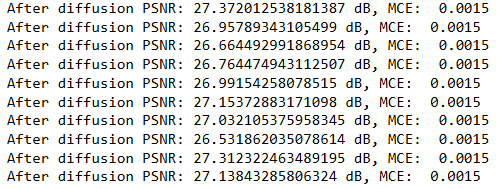
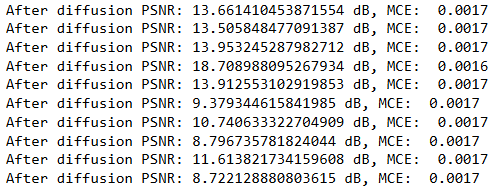

## 4 Branches MCE
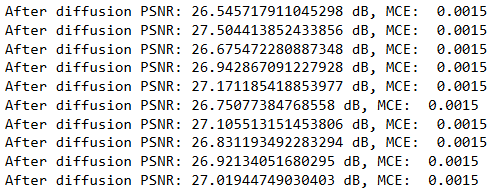
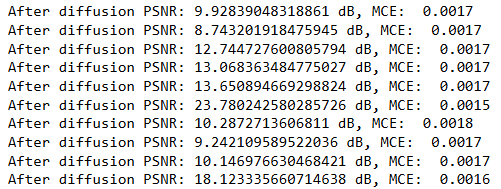

## 8 Branches MCE
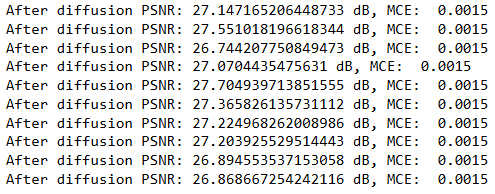
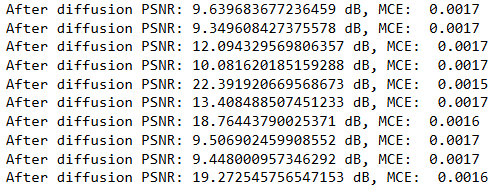

In [ ]:
psnr_values = []
for i in range(num_runs):
    #plt.imshow(run_results[i])
    psnr_value = compute_psnr(np.array(run_results[i]), np.array(gt.cpu().detach().numpy()[0].transpose(1,2,0)))
    psnr_values.append(psnr_value)
    print(f"After diffusion PSNR: {psnr_value} dB, MCE: {mce_results[i]: .4f}")

In [ ]:
plt.hist(psnr_values, bins = 30, alpha = 0.8, edgecolor = 'black')
plt.xlabel("PSNR (dB)")
plt.ylabel("Frequency")
plt.title(f"Distribution of PSNR Values on {num_runs} Runs of Image {filename} with Random Input")
plt.grid(True)
plt.show()

## Make one file for multi run testing ##

In [ ]:
import os, time, json, math
import numpy as np
import pandas as pd
from collections import defaultdict

def _make_step_labels(scheduler, include_init=True):
    """
    Build labels like: ['initial', f"t{t}", ..., 't0'] matching scheduler.timesteps.
    """
    labels = []
    if include_init:
        labels.append("initial")
    # timesteps is typically descending (e.g., [999, 979, ...])
    for t in list(scheduler.timesteps):
        labels.append(f"t{int(t)}")
    return labels

class DMRunRecorder:
    """
    Accumulates per-run traces and PSNRs for one image,
    then computes per-image aggregates and returns tidy + wide DataFrames.
    """
    def __init__(self, image_id, scheduler):
        self.image_id = image_id
        self.scheduler = scheduler
        self.step_labels = _make_step_labels(scheduler, include_init=True)
        self.num_steps = len(self.step_labels)  # initial + len(timesteps)
        self._per_run_mce_traces = []  # list of list[float] length == num_steps
        self._per_run_final_psnr = []  # list[float]
        self._per_run_final_mce  = []  # list[float]

    def record_run(self, init_mce, mce_trace_per_step, final_psnr):
        """
        init_mce: float
        mce_trace_per_step: list of floats for *each diffusion step in order of scheduler.timesteps*.
            We'll prepend init_mce so final length is num_steps.
        final_psnr: float
        """
        assert isinstance(mce_trace_per_step, (list, tuple)), "mce_trace_per_step must be a list"
        trace = [float(init_mce)] + [float(x) for x in mce_trace_per_step]
        if len(trace) != self.num_steps:
            raise ValueError(
                f"MCE trace length mismatch for image {self.image_id}: "
                f"got {len(trace)}, expected {self.num_steps} "
                f"(= 1 init + {len(self.step_labels)-1} steps)"
            )
        self._per_run_mce_traces.append(trace)
        self._per_run_final_psnr.append(float(final_psnr))
        self._per_run_final_mce.append(float(trace[-1]))

    def to_dataframes(self):
        """
        Returns:
          tidy_df: long table with (image, run, step_idx, step_label, mce)
          per_image_summary_df: one row with per-step averages and changes, plus psnr_avg
        """
        n_runs = len(self._per_run_mce_traces)
        # --- Tidy long table ---
        tidy_rows = []
        for r, trace in enumerate(self._per_run_mce_traces, start=1):
            for k, (label, mce_val) in enumerate(zip(self.step_labels, trace)):
                tidy_rows.append({
                    "image": self.image_id,
                    "run": r,
                    "step_idx": k,
                    "step_label": label,
                    "mce": float(mce_val),
                })
        tidy_df = pd.DataFrame(tidy_rows)

        # --- Per-image averages per step ---
        traces = np.array(self._per_run_mce_traces, dtype=float)  # shape (n_runs, num_steps)
        step_means = traces.mean(axis=0)                # avg MCE per step
        change_from_init = step_means - step_means[0]   # Δ vs initial per step
        # Δ vs previous (NaN at initial)
        change_from_prev = np.empty_like(step_means)
        change_from_prev[:] = np.nan
        change_from_prev[1:] = step_means[1:] - step_means[:-1]

        psnr_avg = float(np.mean(self._per_run_final_psnr)) if len(self._per_run_final_psnr) else np.nan

        # Build a single-row wide summary with:
        #   MCE_<label>, dInit_<label>, dPrev_<label>, and final_psnr_avg
        summary = {"image": self.image_id, "final_psnr_avg": psnr_avg}
        for lbl, m, dI, dP in zip(self.step_labels, step_means, change_from_init, change_from_prev):
            summary[f"MCE_{lbl}"]   = float(m)
            summary[f"dInit_{lbl}"] = float(dI)
            summary[f"dPrev_{lbl}"] = float(dP) if not math.isnan(dP) else np.nan

        per_image_summary_df = pd.DataFrame([summary])
        return tidy_df, per_image_summary_df


In [ ]:
# --- Config (as you already have) ---
out = []
n_step = 20
scheduler.set_timesteps(num_inference_steps=n_step)
step_size = 1000 // n_step
dtype = torch.float32

# Where to save the outputs:
export_dir = "./dm_results_exports"
os.makedirs(export_dir, exist_ok=True)

# Collect all images’ tidy/wide in memory to write one combined CSV per type
all_tidy = []
all_summary = []

for j in range(11, 12):
    filename = f"{j:05d}.png"   # 00011 ... 00020
    filepath = os.path.join("/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/data/demo_remain/", filename)

    gt_img = Image.open(filepath).convert("RGB")
    ref_numpy = np.array(gt_img).astype(np.float32) / 255.0
    x = ref_numpy * 2 - 1
    x = x.transpose(2, 0, 1)
    ref_img = torch.tensor(x, dtype=dtype, device=device).unsqueeze(0)
    ref_img.requires_grad = False

    # Forward measurement model (Ax + n)
    if measure_config['operator']['name'] == 'inpainting':
        measurement_cond_fn = partial(cond_method.conditioning, mask=mask)
        sample_fn = partial(sample_fn, measurement_cond_fn=measurement_cond_fn)
        y = operator.forward(ref_img, mask=mask)
        y_n = noiser(y)
    else:
        y = operator.forward(ref_img)
        y_n = noiser(y)

    gt = (ref_img / 2 + 0.5)  # in [0,1] torch
    gt_np = gt.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # (H,W,C) in [0,1]
    
    gt = (ref_img/2+0.5)
    # resize_transform = torchvision.transforms.Resize((256,256))

    num_runs = 2
    print(f"Reconstructing Image {filename}...")

    # Create per-image recorder
    rec = DMRunRecorder(image_id=f"{j:05d}", scheduler=scheduler)

    for run_iter in range(num_runs):
        # fresh init
        input =torch.randn((1, 3, 256, 256), device=device, dtype=dtype).clone().detach().requires_grad_(True)
        noise = torch.randn(input.shape)*((1-scheduler.alphas_cumprod[-1])**0.5)
        input = torch.tensor(input)*((scheduler.alphas_cumprod[-1])**0.5) + noise.to(device)

        # Initial MCE (using the *current sample*; for pure theory you might prefer pred_original_sample @ init)
        init_mce = compute_mce(input, y_n.abs(), target_shape=y_n.shape)

        # Will store MCE at each diffusion step
        mce_trace = []

        # Diffusion sweep
        pred_original_sample = None  # keep last
        for i, t in enumerate(scheduler.timesteps):
            prev_timestep = t - step_size
            alpha_prod_t = scheduler.alphas_cumprod[t]
            alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.alphas_cumprod[0]
            beta_prod_t = 1 - alpha_prod_t
            sqrt_one_minus_alpha_cumprod = beta_prod_t ** 0.5

            # Optimize current latent toward measurement consistency (your routine)
            input, pred_original_sample, noise_pred = optimize_input(
                input.clone(),
                sqrt_one_minus_alpha_cumprod,
                alpha_prod_t ** 0.5,
                t,
                num_steps=20,
                learning_rate=0.075
            )
            

            # Compute MCE on denoised image proxy
            phase_image = (pred_original_sample / 2 + 0.5).clamp(0, 1)
            mce_val = compute_mce(phase_image, y_n.abs(), target_shape=y_n.shape)
            mce_trace.append(float(mce_val))

            # Prepare next step x_{t-1}
            input = pred_original_sample * (alpha_prod_t_prev ** 0.5) + (1 - alpha_prod_t_prev) ** 0.5 * torch.randn_like(input)

        # Final recon for PSNR (use last pred_original_sample)
        phase_image = (pred_original_sample / 2 + 0.5).clamp(0, 1)
        recon_np = phase_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        final_psnr = float(compute_psnr(recon_np, gt_np))

        # Record the run (this stores [init] + per-step MCE trace under the hood)
        rec.record_run(init_mce=float(init_mce), mce_trace_per_step=mce_trace, final_psnr=final_psnr)

    # After all runs for this image: convert to DataFrames
    tidy_df, summary_df = rec.to_dataframes()

    # Save per-image (optional)
    ts = time.strftime("%Y%m%d-%H%M%S")
    tidy_path    = os.path.join(export_dir, f"{j:05d}_runs_tidy_{ts}.csv")
    summary_path = os.path.join(export_dir, f"{j:05d}_summary_{ts}.csv")
    tidy_df.to_csv(tidy_path, index=False)
    summary_df.to_csv(summary_path, index=False)

    # Accumulate for global combined files
    all_tidy.append(tidy_df)
    all_summary.append(summary_df)

# Write global combined CSVs (all images)
tidy_all = pd.concat(all_tidy, ignore_index=True)
summary_all = pd.concat(all_summary, ignore_index=True)
tidy_all_path = os.path.join(export_dir, f"ALL_images_runs_tidy_{n_step}.csv")
summary_all_path = os.path.join(export_dir, f"ALL_images_summary_wide_{n_step}.csv")
tidy_all.to_csv(tidy_all_path, index=False)
summary_all.to_csv(summary_all_path, index=False)

# Optional: write one consolidated Excel with two sheets
# xlsx_path = os.path.join(export_dir, "ALL_images_results.xlsx")
# with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as writer:
#    tidy_all.to_excel(writer, sheet_name="runs_tidy", index=False)
#    summary_all.to_excel(writer, sheet_name="summary_wide", index=False)

print("Saved:", tidy_all_path, summary_all_path, xlsx_path)

In [ ]:
# --- Long-format exporters (place this right after you have tidy_all & summary_all) ---
import os
import re
import pandas as pd
import numpy as np

# 0) Make sure your export dir exists
export_dir = "./dm_results_exports"
os.makedirs(export_dir, exist_ok=True)

# 1) Save per-run tidy exactly as-is (already long)
tidy_all_path = os.path.join(export_dir, f"ALL_images_runs_tidy_{n_step}.csv")
tidy_all.to_csv(tidy_all_path, index=False)

# 2) Convert per-image "wide" summary to long, with clean step ordering
def _step_sort_key(lbl: str):
    # order: initial first, then t<...> descending (t1000, t950, ..., t0)
    if lbl == "initial":
        return (0, 0)  # smallest
    m = re.fullmatch(r"t(\d+)", lbl)
    if m:
        return (1, -int(m.group(1)))  # descending by numeric
    # put anything unknown last, stable order
    return (2, lbl)

def summary_wide_to_long(summary_wide_df: pd.DataFrame) -> pd.DataFrame:
    """
    Input columns include:
      - image
      - final_psnr_avg
      - MCE_<label>, dInit_<label>, dPrev_<label> for labels in {'initial','tXXXX',...}
    Output long DF (one row per image, per step label):
      image, step_idx, step_label, avg_mce, dInit, dPrev
    Plus an extra row with step_label='final_psnr' containing final_psnr_avg.
    """
    rows = []
    for _, row in summary_wide_df.iterrows():
        img = row["image"]
        # discover labels present by scanning MCE_* keys
        labels = [k.replace("MCE_", "") for k in row.index if str(k).startswith("MCE_")]
        labels = sorted(labels, key=_step_sort_key)

        for k, lbl in enumerate(labels):
            mce   = float(row[f"MCE_{lbl}"])
            dInit = float(row.get(f"dInit_{lbl}", np.nan))
            dPrev = float(row.get(f"dPrev_{lbl}", np.nan))
            rows.append({
                "image": img,
                "step_idx": k,
                "step_label": lbl,
                "avg_mce": mce,
                "dInit": dInit,
                "dPrev": dPrev,
            })

        # append PSNR as one special row (no MCE/diffs there)
        rows.append({
            "image": img,
            "step_idx": len(labels),          # after the last step
            "step_label": "final_psnr",
            "avg_mce": np.nan,
            "dInit": np.nan,
            "dPrev": np.nan,
            "final_psnr_avg": float(row["final_psnr_avg"]),
        })

    return pd.DataFrame(rows)

# 5 decimal places everywhere; no scientific notation
step_averages_long = summary_wide_to_long(summary_all)
step_averages_long_path = os.path.join(export_dir, f"ALL_images_step_averages_long_{n_step}.csv")
step_averages_long.to_csv(step_averages_long_path, index=False)


# 3) (Optional) Ultra-tidy molten table: one value per row (handy for seaborn/plotnine)
#    Produces rows like: (image, step_idx, step_label, metric, value)
def melt_step_averages_long(df: pd.DataFrame) -> pd.DataFrame:
    part_mce = df.loc[df["step_label"] != "final_psnr",
                      ["image","step_idx","step_label","avg_mce","dInit","dPrev"]].copy()
    melted_mce = part_mce.melt(id_vars=["image","step_idx","step_label"],
                               value_vars=["avg_mce","dInit","dPrev"],
                               var_name="metric",
                               value_name="value")
    part_psnr = df.loc[df["step_label"] == "final_psnr",
                       ["image","step_idx","step_label","final_psnr_avg"]].copy()
    part_psnr = part_psnr.rename(columns={"final_psnr_avg":"value"})
    part_psnr["metric"] = "final_psnr_avg"
    part_psnr = part_psnr[["image","step_idx","step_label","metric","value"]]
    return pd.concat([melted_mce, part_psnr], ignore_index=True)

metrics_long = melt_step_averages_long(step_averages_long)
metrics_long_path = os.path.join(export_dir, "ALL_images_metrics_long.csv")
metrics_long.to_csv(metrics_long_path, index=False)

tidy_all.to_csv(tidy_all_path, index=False, float_format="%.5f")
step_averages_long.to_csv(step_averages_long_path, index=False, float_format="%.5f")
metrics_long.to_csv(metrics_long_path, index=False, float_format="%.5f")

print("Saved long-format files:")
print(" • Per-run tidy:", tidy_all_path)
print(" • Per-image step averages (long):", step_averages_long_path)
print(" • (Optional) Ultra-tidy metric/value table:", metrics_long_path)


No Pandas -- Try This

In [ ]:
# ======== NO-PANDAS RECORDER + EXPORTS ========
import os, time, json, math, csv
import numpy as np

# ----- formatting helpers -----
# --- helper: pretty-print an MCE trace for one run ---
def print_mce_trace(run_idx: int, mces, timesteps):
    """
    mces: list[Tensor/float] with [init_mce, mce_at_t_0, mce_at_t_1, ...]
    timesteps: iterable of scheduler timesteps aligned with mces[1:]
    """
    # ensure plain floats for printing
    mces_f = [float(m) for m in mces]

    print(f"\nMCE trace for run {run_idx + 1}:")
    print(f"  init: {mces_f[0]:.4f}")
    for k, (t, m) in enumerate(zip(timesteps, mces_f[1:]), 1):
        # right-aligned columns: step, t, value
        print(f"  step {k:3d} (t={int(t):5d}): {m:8.4f}")
    print()  # blank line for spacing
    
def is_nan(x):
    try:
        return np.isnan(x)
    except Exception:
        return False

def fmt5(x):
    """Format floats to 5 decimals; return '' for NaN/None."""
    if x is None or is_nan(x):
        return ""
    return f"{float(x):.5f}"

def fmt2(x):
    if x is None or is_nan(x):
        return ""
    return f"{float(x):.2f}"

# ----- step label helpers -----
def _make_step_labels(scheduler, include_init=True):
    labels = []
    if include_init:
        labels.append("initial")
    for t in list(scheduler.timesteps):  # typically descending
        labels.append(f"t{int(t)}")
    return labels

def _step_sort_key(lbl: str):
    # order: initial first, then t<...> descending (t1000, t950, ..., t0)
    if lbl == "initial":
        return (0, 0)
    if lbl.startswith("t") and lbl[1:].isdigit():
        return (1, -int(lbl[1:]))
    return (2, lbl)

# ----- recorder without pandas -----
class DMRunRecorderNP:
    """
    Accumulates per-run MCE traces and PSNRs for one image,
    then produces tidy rows and a single wide summary dict.
    """
    def __init__(self, image_id, scheduler):
        self.image_id = image_id
        self.scheduler = scheduler
        self.step_labels = _make_step_labels(scheduler, include_init=True)
        self.num_steps = len(self.step_labels)
        self._per_run_mce_traces = []  # list[list[float]] length = num_steps
        self._per_run_final_psnr = []  # list[float]

    def record_run(self, init_mce, mce_trace_per_step, final_psnr):
        assert isinstance(mce_trace_per_step, (list, tuple)), "mce_trace_per_step must be list/tuple"
        trace = [float(init_mce)] + [float(x) for x in mce_trace_per_step]
        if len(trace) != self.num_steps:
            raise ValueError(
                f"MCE trace length mismatch for image {self.image_id}: "
                f"got {len(trace)}, expected {self.num_steps} "
                f"(= 1 init + {len(self.step_labels)-1} steps)"
            )
        self._per_run_mce_traces.append(trace)
        self._per_run_final_psnr.append(float(final_psnr))

    def to_records(self):
        """
        Returns:
          tidy_rows: list of dicts: {image, run, step_idx, step_label, mce}
          summary_row: dict with keys:
            - 'image', 'final_psnr_avg'
            - 'MCE_<label>', 'dInit_<label>', 'dPrev_<label>' for each step label
        """
        # --- tidy rows (long per-run) ---
        tidy_rows = []
        for r, trace in enumerate(self._per_run_mce_traces, start=1):
            for k, (label, mce_val) in enumerate(zip(self.step_labels, trace)):
                tidy_rows.append({
                    "image": self.image_id,
                    "run": r,
                    "step_idx": k,
                    "step_label": label,
                    "mce": float(mce_val),
                })

        # --- per-image averages per step ---
        traces = np.array(self._per_run_mce_traces, dtype=float)  # (n_runs, num_steps)
        step_means = traces.mean(axis=0) if traces.size > 0 else np.full(self.num_steps, np.nan)
        dInit = step_means - step_means[0] if traces.size > 0 else np.full(self.num_steps, np.nan)
        dPrev = np.full(self.num_steps, np.nan)
        if traces.size > 0:
            dPrev[1:] = step_means[1:] - step_means[:-1]

        psnr_avg = float(np.mean(self._per_run_final_psnr)) if len(self._per_run_final_psnr) else np.nan

        summary_row = {"image": self.image_id, "final_psnr_avg": psnr_avg}
        for lbl, m, di, dp in zip(self.step_labels, step_means, dInit, dPrev):
            summary_row[f"MCE_{lbl}"]   = float(m)
            summary_row[f"dInit_{lbl}"] = float(di)
            summary_row[f"dPrev_{lbl}"] = float(dp)
        return tidy_rows, summary_row

# ----- CSV writing helpers (no pandas) -----
def write_runs_tidy_csv(path, rows):
    # rows: list of dicts with keys ["image","run","step_idx","step_label","mce"]
    header = ["image","run","step_idx","step_label","mce"]
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(header)
        for r in rows:
            w.writerow([
                r["image"], int(r["run"]), int(r["step_idx"]), r["step_label"], fmt5(r["mce"])
            ])

def build_summary_wide_header(step_labels):
    header = ["image", "final_psnr_avg"]
    for lbl in step_labels:
        header += [f"MCE_{lbl}", f"dInit_{lbl}", f"dPrev_{lbl}"]
    return header

def write_summary_wide_csv(path, rows, step_labels):
    # rows: list of summary_row dicts from recorder
    header = build_summary_wide_header(step_labels)
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(header)
        for r in rows:
            row_out = [r["image"], fmt5(r.get("final_psnr_avg", np.nan))]
            for lbl in step_labels:
                row_out.append(fmt5(r.get(f"MCE_{lbl}", np.nan)))
                row_out.append(fmt5(r.get(f"dInit_{lbl}", np.nan)))
                row_out.append(fmt5(r.get(f"dPrev_{lbl}", np.nan)))
            w.writerow(row_out)

def summary_wide_to_step_averages_long(summary_rows, step_labels):
    """
    summary_rows: list of summary_row dicts
    Returns list of dict rows:
      - for MCE steps: {image, step_idx, step_label, avg_mce, dInit, dPrev}
      - for PSNR:      {image, step_idx, step_label='final_psnr', final_psnr_avg}
    """
    out = []
    # ensure sorted step order
    ordered = sorted(step_labels, key=_step_sort_key)
    for r in summary_rows:
        img = r["image"]
        for k, lbl in enumerate(ordered):
            out.append({
                "image": img,
                "step_idx": k,
                "step_label": lbl,
                "avg_mce": r.get(f"MCE_{lbl}", np.nan),
                "dInit":   r.get(f"dInit_{lbl}", np.nan),
                "dPrev":   r.get(f"dPrev_{lbl}", np.nan),
            })
        out.append({
            "image": img,
            "step_idx": len(ordered),
            "step_label": "final_psnr",
            "final_psnr_avg": r.get("final_psnr_avg", np.nan),
        })
    return out

def write_step_averages_long_csv(path, rows):
    # rows: from summary_wide_to_step_averages_long
    # Columns: image, step_idx, step_label, avg_mce, dInit, dPrev, (optional) final_psnr_avg
    header = ["image","step_idx","step_label","avg_mce","dInit","dPrev","final_psnr_avg"]
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(header)
        for r in rows:
            if r["step_label"] == "final_psnr":
                w.writerow([r["image"], int(r["step_idx"]), "final_psnr", "", "", "", fmt5(r["final_psnr_avg"])])
            else:
                w.writerow([
                    r["image"], int(r["step_idx"]), r["step_label"],
                    fmt5(r["avg_mce"]), fmt5(r["dInit"]), fmt5(r["dPrev"]), ""
                ])

def melt_metrics_long(step_avg_long_rows):
    """
    Input: rows from summary_wide_to_step_averages_long
    Output: list of dicts with columns: image, step_idx, step_label, metric, value
    Where metric ∈ {'avg_mce','dInit','dPrev'} for MCE steps, or 'final_psnr_avg' for PSNR row.
    """
    out = []
    for r in step_avg_long_rows:
        if r["step_label"] == "final_psnr":
            out.append({
                "image": r["image"], "step_idx": r["step_idx"], "step_label": "final_psnr",
                "metric": "final_psnr_avg", "value": r.get("final_psnr_avg", np.nan)
            })
        else:
            for mkey in ["avg_mce","dInit","dPrev"]:
                out.append({
                    "image": r["image"], "step_idx": r["step_idx"], "step_label": r["step_label"],
                    "metric": mkey, "value": r.get(mkey, np.nan)
                })
    return out

def write_metrics_long_csv(path, rows):
    header = ["image","step_idx","step_label","metric","value"]
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(header)
        for r in rows:
            w.writerow([r["image"], int(r["step_idx"]), r["step_label"], r["metric"], fmt5(r["value"])])

# ======== INTEGRATE WITH YOUR MAIN LOOP (replace pandas bits) ========

# --- Config (as you already have) ---
out = []
n_step = 20
scheduler.set_timesteps(num_inference_steps=n_step)
step_size = 1000 // n_step
dtype = torch.float32

# Save dir
export_dir = "./dm_results_exports"
os.makedirs(export_dir, exist_ok=True)

all_tidy_rows = []     # accumulate all images' tidy rows
all_summary_rows = []  # accumulate all images' summary rows
global_step_labels = _make_step_labels(scheduler, include_init=True)

for j in range(19, 20):  # adjust range as needed
    filename = f"{j:05d}.png"
    filepath = os.path.join("/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/data/demo_remain/", filename)

    gt_img = Image.open(filepath).convert("RGB")
    ref_numpy = np.array(gt_img).astype(np.float32) / 255.0
    x = ref_numpy * 2 - 1
    x = x.transpose(2, 0, 1)
    ref_img = torch.tensor(x, dtype=dtype, device=device).unsqueeze(0)
    ref_img.requires_grad = False

    # Forward measurement model (Ax + n)
    if measure_config['operator']['name'] == 'inpainting':
        measurement_cond_fn = partial(cond_method.conditioning, mask=mask)
        sample_fn = partial(sample_fn, measurement_cond_fn=measurement_cond_fn)
        y = operator.forward(ref_img, mask=mask)
        y_n = noiser(y)
    else:
        y = operator.forward(ref_img)
        y_n = noiser(y)

    gt = (ref_img / 2 + 0.5)
    gt_np = gt.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    num_runs = 10
    print(f"Reconstructing Image {filename}...")

    rec = DMRunRecorderNP(image_id=f"{j:05d}", scheduler=scheduler)

    for run_iter in range(num_runs):
        # fresh init
        # input = torch.randn((1, 3, 256, 256), device=device, dtype=dtype).clone().detach().requires_grad_(True)
        # noise = torch.randn_like(input) * ((1 - scheduler.alphas_cumprod[-1]) ** 0.5)
        # input = input * (scheduler.alphas_cumprod[-1] ** 0.5) + noise  # avoid torch.tensor(input)
        
        input =torch.randn((1, 3, 256, 256), device=device, dtype=dtype).clone().detach().requires_grad_(True)
        noise = torch.randn(input.shape)*((1-scheduler.alphas_cumprod[-1])**0.5)
        input = torch.tensor(input)*((scheduler.alphas_cumprod[-1])**0.5) + noise.to(device)


        # Initial MCE
        init_mce = compute_mce(input, y_n.abs(), target_shape=y_n.shape)

        mce_trace = []
        pred_original_sample = None

        for i, t in enumerate(scheduler.timesteps):
            prev_timestep = t - step_size
            alpha_prod_t = scheduler.alphas_cumprod[t]
            alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.alphas_cumprod[0]
            beta_prod_t = 1 - alpha_prod_t
            sqrt_one_minus_alpha_cumprod = beta_prod_t ** 0.5

            # Your inner optimizer (ensure it builds a fresh graph per iter, as discussed earlier)
            input, pred_original_sample, noise_pred = optimize_input(
                input.clone(),
                sqrt_one_minus_alpha_cumprod,
                alpha_prod_t ** 0.5,
                t,
                num_steps=20,
                learning_rate=0.075
            )

            phase_image = (pred_original_sample / 2 + 0.5).clamp(0, 1)
            mce_val = compute_mce(phase_image, y_n.abs(), target_shape=y_n.shape)
            mce_trace.append(float(mce_val))

            input = pred_original_sample * (alpha_prod_t_prev ** 0.5) + (1 - alpha_prod_t_prev) ** 0.5 * torch.randn_like(input)

        # Final PSNR
        phase_image = (pred_original_sample / 2 + 0.5).clamp(0, 1)
        recon_np = phase_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        final_psnr = float(compute_psnr(recon_np, gt_np))

        rec.record_run(init_mce=float(init_mce), mce_trace_per_step=mce_trace, final_psnr=final_psnr)

    # Convert to tidy rows + per-image summary row (no pandas)
    tidy_rows, summary_row = rec.to_records()
    # Write per-image (optional)
    ts = time.strftime("%Y%m%d-%H%M%S")
    per_image_tidy_path = os.path.join(export_dir, f"{j:05d}_runs_tidy_{ts}_{j}.csv")
    per_image_summary_path = os.path.join(export_dir, f"{j:05d}_summary_{ts}_{j}.csv")
    write_runs_tidy_csv(per_image_tidy_path, tidy_rows)
    write_summary_wide_csv(per_image_summary_path, [summary_row], rec.step_labels)

    # Accumulate
    all_tidy_rows.extend(tidy_rows)
    all_summary_rows.append(summary_row)

# ---- Write combined CSVs (ALL images) ----
tidy_all_path = os.path.join(export_dir, f"ALL_images_runs_tidy_{n_step}_{j}.csv")
summary_wide_all_path = os.path.join(export_dir, f"ALL_images_summary_wide_{n_step}_{j}.csv")
write_runs_tidy_csv(tidy_all_path, all_tidy_rows)
write_summary_wide_csv(summary_wide_all_path, all_summary_rows, global_step_labels)

# ---- Long per-image step averages (avg_mce, dInit, dPrev) + PSNR row ----
step_averages_long_rows = summary_wide_to_step_averages_long(all_summary_rows, global_step_labels)
step_averages_long_path = os.path.join(export_dir, f"ALL_images_step_averages_long_{n_step}_{j}.csv")
write_step_averages_long_csv(step_averages_long_path, step_averages_long_rows)

# ---- Ultra-tidy metric/value table (optional) ----
metrics_long_rows = melt_metrics_long(step_averages_long_rows)
metrics_long_path = os.path.join(export_dir, f"ALL_images_metrics_long_{n_step}_{j}.csv")
write_metrics_long_csv(metrics_long_path, metrics_long_rows)

print("Saved:")
print(" • Per-run tidy:", tidy_all_path)
print(" • Per-image summary wide:", summary_wide_all_path)
print(" • Per-image step averages (long):", step_averages_long_path)
print(" • Ultra-tidy metric/value table:", metrics_long_path)


Old one

In [ ]:
## Make one file for multi run testing 

out = []
n_step = 20
scheduler.set_timesteps(num_inference_steps=n_step)
step_size = 1000//n_step
dtype = torch.float32

# Loop through images 00011, 00012, …, 00019 etc... i

for j in range(11, 12):
    filename = f"{j:05d}.png"            # 00011, 00012, …, 00019 etc... i
    filepath = os.path.join("/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/data/demo_remain/", filename)
    gt_img = Image.open(filepath).convert("RGB")
    #shutil.copy(gt_img_path, os.path.join(logdir, 'gt.png'))
    ref_numpy = np.array(gt_img).astype(np.float32) / 255.0
    x = ref_numpy * 2 - 1
    x = x.transpose(2, 0, 1)
    ref_img = torch.Tensor(x).to(dtype).to(device).unsqueeze(0)
    ref_img.requires_grad = False
    #ref_img = ref_img.to(device)
    if measure_config['operator'] ['name'] == 'inpainting':
        mask = mask
        measurement_cond_fn = partial(cond_method.conditioning, mask=mask)
        sample_fn = partial(sample_fn, measurement_cond_fn=measurement_cond_fn)

        # Forward measurement model (Ax + n)
        y = operator.forward(ref_img, mask=mask)
        y_n = noiser(y)

    else: 
        # Forward measurement model (Ax + n)
        y = operator.forward(ref_img)
        y_n = noiser(y)
        #y_n = torch.clamp(y_n,-1,1)
    #y_n.requires_grad = False

    gt = (ref_img/2+0.5)
    resize_transform = torchvision.transforms.Resize((256,256))

    # Multi-Run Testing

    num_runs = 2
    run_results = []
    mce_results = []
    per_image_results = []        # optional: collect per-run records for this image

    print(f"Reconstructing Image {filename}...")
    for run_iter in range(num_runs):
        # print('Run Number:', run_iter + 1)
    
        # Clear output visualization in case didn't rerun
        out_visual = []
        measurement_errors = []
    
        input =torch.randn((1, 3, 256, 256), device=device, dtype=dtype).clone().detach().requires_grad_(True)
        noise = torch.randn(input.shape)*((1-scheduler.alphas_cumprod[-1])**0.5)
        input = torch.tensor(input)*((scheduler.alphas_cumprod[-1])**0.5) + noise.to(device)
    
        # Print Initial MCE
        init_mce = compute_mce(input, y_n.abs(), target_shape=y_n.shape) # In practice we don't have access to GT during DMs, otherwise we just know GT
        # print(f"Initial MCE:, {init_mce: .4f}")

        for i, t in enumerate(scheduler.timesteps):
            prev_timestep = t - step_size

            alpha_prod_t = scheduler.alphas_cumprod[t]
            alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.alphas_cumprod[0]

            beta_prod_t = 1 - alpha_prod_t
            sqrt_one_minus_alpha_cumprod = beta_prod_t**0.5


            #for k in range(1):
            input, pred_original_sample, noise_pred= optimize_input(input.clone(), sqrt_one_minus_alpha_cumprod, alpha_prod_t**0.5, t, num_steps=20, learning_rate=0.075)
            #    input= pred_original_sample * alpha_prod_t**0.5+(1-alpha_prod_t)**0.5*torch.randn(input.size()).to(device)
        
            phase_image = (pred_original_sample / 2 + 0.5).clamp(0, 1)

            # Compute measurement error with correct shape
            mce = compute_mce(phase_image, y_n.abs(), target_shape=y_n.shape)
            measurement_errors.append(mce)
        
            input = pred_original_sample * alpha_prod_t_prev**0.5+(1-alpha_prod_t_prev)**0.5*torch.randn(input.size()).to(device)

            # print(f"Time: {t}, , MCE: {mce:.4f}")
        input = (input/2+0.5).clamp(0, 1)
        phase_image = (pred_original_sample/2+0.5).clamp(0, 1)
        #input = (input + 1) / 2
        phase_image = phase_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    
        run_results.append(phase_image)
        mce_results.append(mce)
        
        # (A) show the full MCE trace for this run in a neat block
        print_mce_trace(run_iter, measurement_errors, scheduler.timesteps)

        # (B) store results
        run_results.append(phase_image)
        mce_results.append(mce)  # final mce
        per_image_results.append({
            "run": run_iter + 1,
            "init_mce": float(measurement_errors[0]),
            "final_mce": float(measurement_errors[-1]),
            "mce_seq": [float(v) for v in measurement_errors],  # full trace, including init
        })

        psnr_values = []
    for i in range(num_runs):
        #plt.imshow(run_results[i])
        psnr_value = compute_psnr(np.array(run_results[i]), np.array(gt.cpu().detach().numpy()[0].transpose(1,2,0)))
        psnr_values.append(psnr_value)
        print(f"After diffusion PSNR: {psnr_value} dB, MCE: {mce_results[i]: .4f}")



Reconstructing Image 00011.png...
Run Number: 1
/tmp/ipykernel_435532/1188489366.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)*((scheduler.alphas_cumprod[-1])**0.5) + noise.to(device)
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 28.100968456509925 dB, MCE:  0.0015
After diffusion PSNR: 28.270696040092986 dB, MCE:  0.0015
After diffusion PSNR: 11.455024601889816 dB, MCE:  0.0018
After diffusion PSNR: 28.094056601340395 dB, MCE:  0.0015
After diffusion PSNR: 28.05229052845054 dB, MCE:  0.0015
After diffusion PSNR: 11.66003553083227 dB, MCE:  0.0017
After diffusion PSNR: 11.559687522342362 dB, MCE:  0.0017
After diffusion PSNR: 28.188196534392603 dB, MCE:  0.0015
After diffusion PSNR: 28.174921946261616 dB, MCE:  0.0015
After diffusion PSNR: 27.94670647299117 dB, MCE:  0.0015
Reconstructing Image 00012.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 26.940155056594772 dB, MCE:  0.0015
After diffusion PSNR: 26.731576885850366 dB, MCE:  0.0015
After diffusion PSNR: 26.66404642307755 dB, MCE:  0.0015
After diffusion PSNR: 27.3286891149528 dB, MCE:  0.0015
After diffusion PSNR: 27.5034707883839 dB, MCE:  0.0015
After diffusion PSNR: 27.063347006811128 dB, MCE:  0.0015
After diffusion PSNR: 27.474818271877446 dB, MCE:  0.0015
After diffusion PSNR: 27.39552779143446 dB, MCE:  0.0015
After diffusion PSNR: 26.921228538103055 dB, MCE:  0.0015
After diffusion PSNR: 26.60586533247784 dB, MCE:  0.0015
Reconstructing Image 00013.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 11.363108193156277 dB, MCE:  0.0017
After diffusion PSNR: 12.083036982990214 dB, MCE:  0.0017
After diffusion PSNR: 16.64904020110488 dB, MCE:  0.0017
After diffusion PSNR: 9.415043187755677 dB, MCE:  0.0017
After diffusion PSNR: 8.866917820733708 dB, MCE:  0.0017
After diffusion PSNR: 9.646573669323892 dB, MCE:  0.0018
After diffusion PSNR: 20.269110522060153 dB, MCE:  0.0016
After diffusion PSNR: 8.729081822900417 dB, MCE:  0.0017
After diffusion PSNR: 18.484052998158578 dB, MCE:  0.0016
After diffusion PSNR: 19.98795395736829 dB, MCE:  0.0016
Reconstructing Image 00014.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 26.929716242264906 dB, MCE:  0.0015
After diffusion PSNR: 26.985969714366604 dB, MCE:  0.0015
After diffusion PSNR: 27.1693873825237 dB, MCE:  0.0015
After diffusion PSNR: 27.03242907426711 dB, MCE:  0.0015
After diffusion PSNR: 26.689538557373606 dB, MCE:  0.0015
After diffusion PSNR: 26.8395733024615 dB, MCE:  0.0015
After diffusion PSNR: 14.015525037617174 dB, MCE:  0.0016
After diffusion PSNR: 13.540458112686235 dB, MCE:  0.0016
After diffusion PSNR: 16.99490836422439 dB, MCE:  0.0016
After diffusion PSNR: 13.832507705817783 dB, MCE:  0.0016
Reconstructing Image 00015.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 26.792820120253072 dB, MCE:  0.0015
After diffusion PSNR: 27.61752523171412 dB, MCE:  0.0015
After diffusion PSNR: 27.2816830756511 dB, MCE:  0.0015
After diffusion PSNR: 27.251475007559453 dB, MCE:  0.0015
After diffusion PSNR: 23.259608292515747 dB, MCE:  0.0015
After diffusion PSNR: 13.441754281690955 dB, MCE:  0.0016
After diffusion PSNR: 13.142495755413277 dB, MCE:  0.0016
After diffusion PSNR: 27.65922756139282 dB, MCE:  0.0015
After diffusion PSNR: 12.838730532741472 dB, MCE:  0.0015
After diffusion PSNR: 13.055441963791116 dB, MCE:  0.0016
Reconstructing Image 00016.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 26.840034383038983 dB, MCE:  0.0015
After diffusion PSNR: 27.54649289923041 dB, MCE:  0.0015
After diffusion PSNR: 27.72653724075265 dB, MCE:  0.0015
After diffusion PSNR: 27.97125742699196 dB, MCE:  0.0015
After diffusion PSNR: 27.875255593484916 dB, MCE:  0.0015
After diffusion PSNR: 27.738405159443943 dB, MCE:  0.0015
After diffusion PSNR: 27.66921234342825 dB, MCE:  0.0015
After diffusion PSNR: 27.64957848482655 dB, MCE:  0.0015
After diffusion PSNR: 27.793223880376967 dB, MCE:  0.0015
After diffusion PSNR: 27.743999570460307 dB, MCE:  0.0015
Reconstructing Image 00017.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 5.743272710826254 dB, MCE:  0.0018
After diffusion PSNR: 28.798906000257546 dB, MCE:  0.0016
After diffusion PSNR: 6.072536987315037 dB, MCE:  0.0019
After diffusion PSNR: 29.798010102832784 dB, MCE:  0.0016
After diffusion PSNR: 6.301213807972318 dB, MCE:  0.0019
After diffusion PSNR: 29.87369556376093 dB, MCE:  0.0016
After diffusion PSNR: 6.1885579968220625 dB, MCE:  0.0019
After diffusion PSNR: 5.940199347231086 dB, MCE:  0.0019
After diffusion PSNR: 29.82425631453917 dB, MCE:  0.0016
After diffusion PSNR: 5.7959923188265705 dB, MCE:  0.0018
Reconstructing Image 00018.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 24.562092359496937 dB, MCE:  0.0015
After diffusion PSNR: 23.784467321121895 dB, MCE:  0.0015
After diffusion PSNR: 25.996529788705093 dB, MCE:  0.0015
After diffusion PSNR: 24.70376010475503 dB, MCE:  0.0015
After diffusion PSNR: 21.411937894085934 dB, MCE:  0.0015
After diffusion PSNR: 24.390761619050757 dB, MCE:  0.0015
After diffusion PSNR: 24.411338219158726 dB, MCE:  0.0015
After diffusion PSNR: 23.61230814272552 dB, MCE:  0.0015
After diffusion PSNR: 15.035636875019094 dB, MCE:  0.0015
After diffusion PSNR: 26.055713929914674 dB, MCE:  0.0015
Reconstructing Image 00019.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 28.03935703206749 dB, MCE:  0.0015
After diffusion PSNR: 8.808278893364239 dB, MCE:  0.0015
After diffusion PSNR: 28.248407550365442 dB, MCE:  0.0015
After diffusion PSNR: 28.072686061773776 dB, MCE:  0.0015
After diffusion PSNR: 28.225377001623496 dB, MCE:  0.0015
After diffusion PSNR: 27.993134702380956 dB, MCE:  0.0015
After diffusion PSNR: 28.604166988025618 dB, MCE:  0.0015
After diffusion PSNR: 28.248771017924174 dB, MCE:  0.0015
After diffusion PSNR: 9.373544984918373 dB, MCE:  0.0016
After diffusion PSNR: 28.186135946278633 dB, MCE:  0.0015
Reconstructing Image 00020.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 27.631227521988883 dB, MCE:  0.0015
After diffusion PSNR: 27.329056739101052 dB, MCE:  0.0015
After diffusion PSNR: 27.61261121107919 dB, MCE:  0.0015
After diffusion PSNR: 14.489585813764085 dB, MCE:  0.0016
After diffusion PSNR: 27.75191148168183 dB, MCE:  0.0015
After diffusion PSNR: 17.78303706664373 dB, MCE:  0.0015
After diffusion PSNR: 27.783757170769945 dB, MCE:  0.0015
After diffusion PSNR: 15.750993342903797 dB, MCE:  0.0016
After diffusion PSNR: 27.142005428689583 dB, MCE:  0.0015
After diffusion PSNR: 27.940152676962033 dB, MCE:  0.0015
Reconstructing Image 00021.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 27.633408238307045 dB, MCE:  0.0015
After diffusion PSNR: 27.86082722449575 dB, MCE:  0.0015
After diffusion PSNR: 27.493037341698866 dB, MCE:  0.0015
After diffusion PSNR: 25.957219039690766 dB, MCE:  0.0015
After diffusion PSNR: 27.46857552061432 dB, MCE:  0.0015
After diffusion PSNR: 28.08782169024601 dB, MCE:  0.0015
After diffusion PSNR: 27.702768071998 dB, MCE:  0.0015
After diffusion PSNR: 27.42008259849309 dB, MCE:  0.0015
After diffusion PSNR: 27.52073730703134 dB, MCE:  0.0015
After diffusion PSNR: 27.579953984064403 dB, MCE:  0.0015
Reconstructing Image 00022.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 14.901366177258575 dB, MCE:  0.0015
After diffusion PSNR: 12.71349172138037 dB, MCE:  0.0016
After diffusion PSNR: 15.440604824776132 dB, MCE:  0.0015
After diffusion PSNR: 12.82896302130289 dB, MCE:  0.0016
After diffusion PSNR: 20.573017083742855 dB, MCE:  0.0015
After diffusion PSNR: 13.546121083431686 dB, MCE:  0.0016
After diffusion PSNR: 14.784194750770382 dB, MCE:  0.0016
After diffusion PSNR: 13.367328713870377 dB, MCE:  0.0016
After diffusion PSNR: 21.3134021394038 dB, MCE:  0.0015
After diffusion PSNR: 21.251997337143337 dB, MCE:  0.0015
Reconstructing Image 00023.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 27.621637755416153 dB, MCE:  0.0015
After diffusion PSNR: 27.811321954763145 dB, MCE:  0.0015
After diffusion PSNR: 27.895848858924044 dB, MCE:  0.0015
After diffusion PSNR: 27.534319962033855 dB, MCE:  0.0015
After diffusion PSNR: 27.61300921728704 dB, MCE:  0.0015
After diffusion PSNR: 27.86293750311696 dB, MCE:  0.0015
After diffusion PSNR: 27.912073257060776 dB, MCE:  0.0015
After diffusion PSNR: 28.11110064973633 dB, MCE:  0.0015
After diffusion PSNR: 27.768674458919946 dB, MCE:  0.0015
After diffusion PSNR: 28.09685512216681 dB, MCE:  0.0015
Reconstructing Image 00024.png...
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
After diffusion PSNR: 17.48211655066524 dB, MCE:  0.0015
After diffusion PSNR: 23.277887829279514 dB, MCE:  0.0014
After diffusion PSNR: 23.51545800558304 dB, MCE:  0.0014
After diffusion PSNR: 11.037143934600639 dB, MCE:  0.0016
After diffusion PSNR: 24.949964874942697 dB, MCE:  0.0014
After diffusion PSNR: 13.931928073919355 dB, MCE:  0.0016
After diffusion PSNR: 21.19443340334766 dB, MCE:  0.0014
After diffusion PSNR: 13.478402535412243 dB, MCE:  0.0016
After diffusion PSNR: 16.017040692484013 dB, MCE:  0.0016
After diffusion PSNR: 14.512906661177137 dB, MCE:  0.0015

## Trying: Enforce MCE Thresehold and Restrarting ##

Note: Both dont work

In [ ]:
import os, torch, numpy as np, torchvision
import torch.nn.functional as F
from functools import partial
from PIL import Image

# --- assumes you already have: model, device, operator, noiser, measure_config, fft2c_new, ifft2c_new, DDIMScheduler ---

# ========== helpers ==========

def compute_mce(reconstructed_image, measured_magnitude, target_shape=None):
    """L2 error between Fourier magnitude of reconstruction (in [0,1]) and measured magnitude."""
    x_hat = reconstructed_image.clamp(0, 1)
    if target_shape is not None:
        _, _, H, W = x_hat.shape
        target_H, target_W = target_shape[-2], target_shape[-1]
        pad_h = (target_H - H) // 2
        pad_w = (target_W - W) // 2
        x_hat = F.pad(x_hat, (pad_w, pad_w, pad_h, pad_h))
    if not torch.is_complex(x_hat):
        x_hat = x_hat.type(torch.complex64)
    fft_x_hat = torch.view_as_complex(fft2c_new(torch.view_as_real(x_hat)))
    return (fft_x_hat.abs() - measured_magnitude).pow(2).mean().item()

def compute_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse <= 0:
        return float('inf')
    return float(20 * np.log10(1.0 / (mse**0.5)))

@torch.no_grad()
def to_start_latent_from_x0(x0, sqrt_alpha_bar_T, sqrt_one_minus_alpha_bar_T, noise_scale=1.0):
    """
    Given x0 in [-1,1], sample a start latent x_T = sqrt(alpha_bar_T)*x0 + sqrt(1-alpha_bar_T)*noise.
    """
    eps = torch.randn_like(x0) * noise_scale
    return sqrt_alpha_bar_T * x0 + sqrt_one_minus_alpha_bar_T * eps

def optimize_input(
    input_tensor, sqrt_one_minus_alpha_cumprod, sqrt_alpha_cumprod, t, y_n,
    num_steps=20, learning_rate=0.01
):
    """
    One inner optimization block producing (x_t_next, pred_x0, noise_pred).
    Uses your model(x_t, t) -> eps_hat, and a magnitude data term vs y_n.
    """
    x_t = input_tensor.clone().detach().requires_grad_(True)
    opt = torch.optim.Adam([x_t], lr=learning_rate)
    tt = (torch.ones(1, device=x_t.device, dtype=torch.long) * int(t))

    for _ in range(num_steps):
        opt.zero_grad()
        noise_pred = model(x_t, tt)[:, :3]
        pred_x0 = (x_t - sqrt_one_minus_alpha_cumprod * noise_pred) / sqrt_alpha_cumprod
        pred_x0 = torch.clamp(pred_x0, -1, 1)

        # pad and FFT magnitude for the data term
        pad = int((2 / 8.0) * 256)
        x = pred_x0 * 0.5 + 0.5
        x = F.pad(x, (pad, pad, pad, pad))
        if not torch.is_complex(x):
            x = x.type(torch.complex64)
        fft2_m = torch.view_as_complex(fft2c_new(torch.view_as_real(x)))
        out_mag = fft2_m.abs()

        data_loss = torch.norm(out_mag - y_n)**2
        # small tether to keep x_t from drifting too wildly (optional)
        reg_loss = 0.1 * torch.norm(input_tensor.detach() - x_t)**2
        loss = data_loss + reg_loss
        loss.backward()
        opt.step()

    # recompute noise from the final pair (x_t, pred_x0)
    noise = (x_t - sqrt_alpha_cumprod * pred_x0) / sqrt_one_minus_alpha_cumprod
    return x_t.detach(), pred_x0.detach(), noise.detach()

# ========== main loop with threshold-triggered restarts ==========

def run_threshold_restart_experiment(
    image_indices=range(11, 21),
    num_runs=1,
    n_step=20,
    mce_threshold=0.00148,
    max_restarts=5,
    stop_on_hit=False,              # if True, stop as soon as threshold hit once
    restart_noise_scale=0.5,       # 0 = deterministic reuse, 1 = full start noise
    patience_restarts=None,         # e.g. 2: stop if no best-MCE improvement for 2 restarts
    inner_opt_steps=20,
    inner_lr=0.075,
    seed=41
):
    # reproducibility
    torch.manual_seed(seed); np.random.seed(seed)

    scheduler = DDIMScheduler()
    scheduler.set_timesteps(num_inference_steps=n_step)
    step_size = 1000 // n_step

    dtype = torch.float32
    results_table = []  # for stats / correlation

    # Precompute start-time alphas
    T = int(scheduler.timesteps[0].item())  # largest t (close to 1000)
    alpha_bar_T = scheduler.alphas_cumprod[T].item()
    sqrt_alpha_bar_T = alpha_bar_T**0.5
    sqrt_one_minus_alpha_bar_T = (1.0 - alpha_bar_T)**0.5

    for j in image_indices:
        filename = f"{j:05d}.png"
        filepath = os.path.join("/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/data/demo_remain/", filename)
        gt_img = Image.open(filepath).convert("RGB")
        ref_numpy = np.array(gt_img).astype(np.float32) / 255.0
        x = ref_numpy * 2 - 1
        x = x.transpose(2, 0, 1)
        ref_img = torch.tensor(x, dtype=dtype, device=device).unsqueeze(0)
        gt = (ref_img / 2 + 0.5)

        # set up measurement
        if measure_config['operator']['name'] == 'inpainting':
            # you can keep your partial(...) pathway if used elsewhere
            y = operator.forward(ref_img, mask=mask)
        else:
            y = operator.forward(ref_img)
        y_n = noiser(y)  # measured magnitude domain used in losses/MCE

        print(f"\nReconstructing Image {filename}...")
        for run_iter in range(num_runs):
            print(f"  Run {run_iter+1}/{num_runs}")

            # ----- initialize x_T -----
            x0_init = torch.randn((1, 3, 256, 256), device=device, dtype=dtype)
            x_T = to_start_latent_from_x0(
                x0_init, sqrt_alpha_bar_T, sqrt_one_minus_alpha_bar_T, noise_scale=1.0
            )

            best_mce_overall = float('inf')
            best_psnr_overall = -float('inf')
            best_final_image = None

            restart = 0
            no_improve = 0
            while True:
                # one full pass over all timesteps
                measurement_errors = []
                input_t = x_T.clone()

                for i, t in enumerate(scheduler.timesteps):
                    prev_timestep = int(t) - step_size
                    alpha_prod_t = scheduler.alphas_cumprod[int(t)]
                    alpha_prod_t_prev = (
                        scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0
                        else scheduler.alphas_cumprod[0]
                    )
                    beta_prod_t = 1 - alpha_prod_t
                    sqrt_one_minus_alpha_cumprod = beta_prod_t**0.5
                    sqrt_alpha_cumprod = alpha_prod_t**0.5
                    sqrt_alpha_cumprod_prev = alpha_prod_t_prev**0.5

                    input_t, pred_x0, noise_pred = optimize_input(
                        input_t, sqrt_one_minus_alpha_cumprod, sqrt_alpha_cumprod,
                        int(t), y_n, num_steps=inner_opt_steps, learning_rate=inner_lr
                    )

                    # phase image in [0,1]
                    phase_image = (pred_x0 / 2 + 0.5).clamp(0, 1)
                    mce = compute_mce(phase_image, y_n.abs(), target_shape=y_n.shape)
                    measurement_errors.append(mce)
                    print(f"    t={int(t):4d}  MCE={mce:.6f}")

                    # DDIM/ODE next-step latent (ancestral)
                    eps = torch.randn_like(input_t)
                    input_t = sqrt_alpha_cumprod_prev * pred_x0 + (1 - alpha_prod_t_prev)**0.5 * eps

                    # threshold trigger: restart ASAP with warm-start if met
                    if mce >= mce_threshold:
                        print(f"    *** threshold hit ({mce:.6f} ≤ {mce_threshold}) → scheduling restart")
                        # prepare new x_T from current x0 (pred_x0)
                        x_T = to_start_latent_from_x0(
                            pred_x0, sqrt_alpha_bar_T, sqrt_one_minus_alpha_bar_T,
                            noise_scale=restart_noise_scale
                        )
                        break  # break this pass early to restart

                # end of pass: compute final image & stats of this pass
                final_x0 = pred_x0.detach()
                final_img = (final_x0 / 2 + 0.5).clamp(0, 1).squeeze(0).permute(1, 2, 0).cpu().numpy()
                gt_img_np = gt[0].permute(1, 2, 0).detach().cpu().numpy()
                final_psnr = compute_psnr(final_img, gt_img_np)
                final_mce = measurement_errors[-1] if len(measurement_errors) else float('inf')
                min_mce_pass = min(measurement_errors) if len(measurement_errors) else float('inf')

                print(f"    Pass done: final MCE={final_mce:.6f}  min-pass MCE={min_mce_pass:.6f}  PSNR={final_psnr:.3f} dB")

                # track best across restarts (by min MCE in the pass)
                improved = min_mce_pass < best_mce_overall - 1e-9
                if improved:
                    best_mce_overall = min_mce_pass
                    best_psnr_overall = final_psnr
                    best_final_image = final_img
                    no_improve = 0
                else:
                    no_improve += 1

                # stopping conditions for restarts
                hit_threshold = (min_mce_pass <= mce_threshold)
                if stop_on_hit and hit_threshold:
                    print("    Stopping on first hit.")
                    break
                if restart >= max_restarts:
                    print("    Max restarts reached.")
                    break
                if patience_restarts is not None and no_improve >= patience_restarts:
                    print("    Early stop: no improvement across restarts.")
                    break

                # otherwise: prepare next restart if threshold was hit inside the pass
                restart += 1
                if not hit_threshold:
                    # even if not hit, we can still warm-start next pass from best x0 of this pass
                    x_T = to_start_latent_from_x0(
                        final_x0, sqrt_alpha_bar_T, sqrt_one_minus_alpha_bar_T,
                        noise_scale=restart_noise_scale
                    )
                    print(f"    Restarting (no threshold hit). Restart #{restart}")

            # record final stats for this run (use the best of the restarts)
            results_table.append({
                "image": filename,
                "run": run_iter,
                "best_mce_overall": best_mce_overall,
                "best_psnr_overall": best_psnr_overall,
                "max_restarts": max_restarts,
                "restart_noise_scale": restart_noise_scale,
                "threshold": mce_threshold,
                "n_steps": n_step,
            })
            print(f"  ==> Best-overall for run: MCE={best_mce_overall:.6f}, PSNR={best_psnr_overall:.3f} dB")

    # correlation check across all images/runs
    mces = np.array([r["best_mce_overall"] for r in results_table], dtype=float)
    psnrs = np.array([r["best_psnr_overall"] for r in results_table], dtype=float)
    if len(mces) >= 2 and np.std(mces) > 0 and np.std(psnrs) > 0:
        corr = float(np.corrcoef(mces, psnrs)[0,1])
    else:
        corr = float('nan')

    print("\n=== Summary ===")
    print(f"Runs (total): {len(results_table)}")
    print(f"Pearson corr(best_MCE, best_PSNR): {corr:.4f} (expect negative if smaller MCE → higher PSNR)")
    return results_table, corr


In [ ]:
results, corr = run_threshold_restart_experiment()

In [ ]:
# --- Add these helpers somewhere below the experiment function ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def save_results_to_csv(results_table, csv_path="threshold_restart_results_con.csv"):
    """
    Save the per-run summary rows returned by run_threshold_restart_experiment()
    to a CSV. Each row contains: image, run, best_mce_overall, best_psnr_overall, etc.
    """
    df = pd.DataFrame(results_table)
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} rows to {csv_path}")
    return csv_path

def plot_psnr_vs_mce(results_table, png_path="psnr_vs_mce_con.png"):
    """
    Scatter plot of best PSNR [dB] vs best MCE (lower is better).
    Annotates Pearson correlation r in the title.
    """
    mces  = np.array([r["best_mce_overall"]  for r in results_table], dtype=float)
    psnrs = np.array([r["best_psnr_overall"] for r in results_table], dtype=float)

    # guard against degenerate cases
    if len(mces) < 2 or np.std(mces) == 0 or np.std(psnrs) == 0:
        r = float('nan')
    else:
        r = float(np.corrcoef(mces, psnrs)[0, 1])

    plt.figure()
    plt.scatter(mces, psnrs, s=16)
    plt.xlabel("Best MCE (lower is better)")
    plt.ylabel("Best PSNR [dB] (higher is better)")
    plt.title(f"PSNR vs MCE (Pearson r = {r:.3f}, n = {len(mces)})")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(png_path, dpi=150)
    plt.close()
    print(f"Saved scatter plot to {png_path} (r = {r:.3f})")
    return png_path, r


In [ ]:
csv_path = save_results_to_csv(results)          # -> "threshold_restart_results.csv"
png_path, r = plot_psnr_vs_mce(results)          # -> "psnr_vs_mce.png", correlation value


In [ ]:
import os, torch, numpy as np, torchvision
import torch.nn.functional as F
from PIL import Image

# ===== Helpers (same API as before) =====

def compute_mce(reconstructed_image, measured_magnitude, target_shape=None):
    x_hat = reconstructed_image.clamp(0, 1)
    if target_shape is not None:
        _, _, H, W = x_hat.shape
        target_H, target_W = target_shape[-2], target_shape[-1]
        pad_h = (target_H - H) // 2
        pad_w = (target_W - W) // 2
        x_hat = F.pad(x_hat, (pad_w, pad_w, pad_h, pad_h))
    if not torch.is_complex(x_hat):
        x_hat = x_hat.type(torch.complex64)
    fft_x_hat = torch.view_as_complex(fft2c_new(torch.view_as_real(x_hat)))
    return (fft_x_hat.abs() - measured_magnitude).pow(2).mean().item()

def compute_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse <= 0:
        return float('inf')
    return float(20 * np.log10(1.0 / (mse**0.5)))

@torch.no_grad()
def to_start_latent_from_x0(x0, sqrt_alpha_bar_T, sqrt_one_minus_alpha_bar_T, noise_scale=1.0):
    eps = torch.randn_like(x0) * noise_scale
    return sqrt_alpha_bar_T * x0 + sqrt_one_minus_alpha_bar_T * eps

def optimize_input(
    input_tensor, sqrt_one_minus_alpha_cumprod, sqrt_alpha_cumprod, t, y_n,
    num_steps=20, learning_rate=0.075
):
    """
    One inner optimization block producing (x_t_next, pred_x0, noise_pred).
    Assumes global: `model` on correct device, expects (x_t, t_long).
    """
    x_t = input_tensor.clone().detach().requires_grad_(True)
    opt = torch.optim.Adam([x_t], lr=learning_rate)
    tt = (torch.ones(1, device=x_t.device, dtype=torch.long) * int(t))

    for _ in range(num_steps):
        opt.zero_grad()
        noise_pred = model(x_t, tt)[:, :3]
        pred_x0 = (x_t - sqrt_one_minus_alpha_cumprod * noise_pred) / sqrt_alpha_cumprod
        pred_x0 = torch.clamp(pred_x0, -1, 1)

        # data term in magnitude space (mirror the inner-loop forward exactly)
        pad = int((2 / 8.0) * 256)
        x = pred_x0 * 0.5 + 0.5
        x = F.pad(x, (pad, pad, pad, pad))
        if not torch.is_complex(x):
            x = x.type(torch.complex64)
        fft2_m = torch.view_as_complex(fft2c_new(torch.view_as_real(x)))
        out_mag = fft2_m.abs()

        data_loss = torch.norm(out_mag - y_n)**2
        reg_loss = 0.1 * torch.norm(input_tensor.detach() - x_t)**2
        loss = data_loss + reg_loss
        loss.backward()
        opt.step()

    noise = (x_t - sqrt_alpha_cumprod * pred_x0) / sqrt_one_minus_alpha_cumprod
    return x_t.detach(), pred_x0.detach(), noise.detach()

# ===== Main: end-of-pass restart logic (Path A) =====

def run_threshold_restart_experiment(
    image_indices=range(11, 12),
    num_runs=1,
    n_step=20,
    mce_threshold=0.0015,
    restart_policy="bad_warm",     # "good_refine" | "bad_warm" | "bad_random"
    max_restarts=10,
    patience_restarts=None,        # e.g., 2: stop if best MCE doesn't improve across this many restarts
    restart_noise_scale=0.5,      # used for warm starts
    inner_opt_steps=20,
    inner_lr=0.075,
    seed=0,
):
    """
    End-of-pass decision only. No step-level restarts.
    Requires globals: model, device, operator, noiser, measure_config, fft2c_new, ifft2c_new, DDIMScheduler
    """
    # reproducibility
    torch.manual_seed(seed); np.random.seed(seed)

    scheduler = DDIMScheduler()
    scheduler.set_timesteps(num_inference_steps=n_step)
    step_size = 1000 // n_step

    dtype = torch.float32
    results_table = []

    # Precompute start-time alphas (largest t in schedule)
    T = int(scheduler.timesteps[0].item())
    alpha_bar_T = scheduler.alphas_cumprod[T].item()
    sqrt_alpha_bar_T = alpha_bar_T**0.5
    sqrt_one_minus_alpha_bar_T = (1.0 - alpha_bar_T)**0.5

    for j in image_indices:
        filename = f"{j:05d}.png"
        filepath = os.path.join(
            "/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/data/demo_remain/",
            filename
        )
        gt_img = Image.open(filepath).convert("RGB")
        ref_numpy = np.array(gt_img).astype(np.float32) / 255.0
        x = ref_numpy * 2 - 1
        x = x.transpose(2, 0, 1)
        ref_img = torch.tensor(x, dtype=dtype, device=device).unsqueeze(0)
        gt = (ref_img / 2 + 0.5)

        # forward/measurement
        if measure_config['operator']['name'] == 'inpainting':
            y = operator.forward(ref_img, mask=mask)
        else:
            y = operator.forward(ref_img)
        y_n = noiser(y)

        print(f"\nReconstructing Image {filename}...")
        for run_iter in range(num_runs):
            print(f"  Run {run_iter+1}/{num_runs}")

            # initial latent x_T (random)
            x0_init = torch.randn((1, 3, 256, 256), device=device, dtype=dtype)
            x_T = to_start_latent_from_x0(x0_init, sqrt_alpha_bar_T, sqrt_one_minus_alpha_bar_T, noise_scale=1.0)

            best_mce_overall = float('inf')
            best_psnr_overall = -float('inf')
            best_final_image = None
            no_improve = 0
            restart = 0
            passes_used = 0

            while True:
                measurement_errors = []
                input_t = x_T.clone()
                passes_used += 1

                # ===== Full pass over the schedule; NO step-level restarts =====
                for i, t in enumerate(scheduler.timesteps):
                    prev_timestep = int(t) - step_size
                    alpha_prod_t = scheduler.alphas_cumprod[int(t)]
                    alpha_prod_t_prev = (
                        scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0
                        else scheduler.alphas_cumprod[0]
                    )
                    beta_prod_t = 1 - alpha_prod_t
                    sqrt_one_minus_alpha_cumprod = beta_prod_t**0.5
                    sqrt_alpha_cumprod = alpha_prod_t**0.5
                    sqrt_alpha_cumprod_prev = alpha_prod_t_prev**0.5

                    input_t, pred_x0, noise_pred = optimize_input(
                        input_t, sqrt_one_minus_alpha_cumprod, sqrt_alpha_cumprod,
                        int(t), y_n, num_steps=inner_opt_steps, learning_rate=inner_lr
                    )

                    phase_image = (pred_x0 / 2 + 0.5).clamp(0, 1)
                    mce = compute_mce(phase_image, y_n.abs(), target_shape=y_n.shape)
                    measurement_errors.append(mce)
                    print(f"    t={int(t):4d}  MCE={mce:.6f}")

                    # ancestral move to previous timestep latent
                    eps = torch.randn_like(input_t)
                    input_t = sqrt_alpha_cumprod_prev * pred_x0 + (1 - alpha_prod_t_prev)**0.5 * eps

                # ===== End-of-pass statistics & decision =====
                final_x0 = pred_x0.detach()
                final_img = (final_x0 / 2 + 0.5).clamp(0, 1).squeeze(0).permute(1, 2, 0).cpu().numpy()
                gt_img_np = gt[0].permute(1, 2, 0).detach().cpu().numpy()
                final_psnr = compute_psnr(final_img, gt_img_np)
                final_mce  = measurement_errors[-1] if measurement_errors else float('inf')
                min_mce_pass = min(measurement_errors) if measurement_errors else float('inf')

                print(f"    Pass done: final MCE={final_mce:.6f}  min-pass MCE={min_mce_pass:.6f}  PSNR={final_psnr:.3f} dB")

                # track best across passes
                improved = min_mce_pass < best_mce_overall - 1e-12
                if improved:
                    best_mce_overall = min_mce_pass
                    best_psnr_overall = final_psnr
                    best_final_image = final_img
                    no_improve = 0
                else:
                    no_improve += 1

                # decide whether to restart another pass (END-OF-PASS ONLY)
                trigger = False
                if restart_policy == "good_refine":
                    trigger = (min_mce_pass <= mce_threshold)
                elif restart_policy in ("bad_warm", "bad_random"):
                    trigger = (min_mce_pass >= mce_threshold)

                # patience & caps
                if patience_restarts is not None and no_improve >= patience_restarts:
                    print("    Early stop: no improvement across passes.")
                    break
                if restart >= max_restarts:
                    print("    Max restarts reached.")
                    break

                if trigger:
                    # prepare x_T for the next pass
                    if restart_policy in ("good_refine", "bad_warm"):
                        # warm start from this pass's x0
                        x_T = to_start_latent_from_x0(
                            final_x0, sqrt_alpha_bar_T, sqrt_one_minus_alpha_bar_T,
                            noise_scale=restart_noise_scale
                        )
                        print(f"    Restarting (policy={restart_policy}).")
                    else:  # bad_random
                        x_T = torch.randn_like(x_T)
                        print("    Restarting (policy=bad_random).")
                    restart += 1
                    continue  # run another full pass
                else:
                    # stop passes for this run
                    break

            # record best-overall for this (image, run)
            results_table.append({
                "image": filename,
                "run": run_iter,
                "best_mce_overall": best_mce_overall,
                "best_psnr_overall": best_psnr_overall,
                "max_restarts": max_restarts,
                "restart_noise_scale": restart_noise_scale,
                "threshold": mce_threshold,
                "n_steps": n_step,
                "restart_policy": restart_policy,
                "passes_used": passes_used,   
            })
            print(f"  ==> Best-overall for run: MCE={best_mce_overall:.6f}, PSNR={best_psnr_overall:.3f} dB")

    # correlation across all (image, run)
    mces  = np.array([r["best_mce_overall"]  for r in results_table], dtype=float)
    psnrs = np.array([r["best_psnr_overall"] for r in results_table], dtype=float)
    if len(mces) >= 2 and np.std(mces) > 0 and np.std(psnrs) > 0:
        corr = float(np.corrcoef(mces, psnrs)[0,1])
    else:
        corr = float('nan')

    print("\n=== Summary ===")
    print(f"Runs (total): {len(results_table)}")
    print(f"Pearson corr(best_MCE, best_PSNR): {corr:.4f} (expect negative if smaller MCE → higher PSNR)")
    return results_table, corr


In [ ]:
run_threshold_restart_experiment()

In [ ]:
def _summarize_runs(results):
    import numpy as np
    if not results:
        return {"n": 0, "mean_best_mce": float('nan'), "median_best_mce": float('nan'),
                "mean_best_psnr": float('nan'), "median_best_psnr": float('nan'),
                "pct_hits_threshold": float('nan'), "mean_passes_used": float('nan')}
    mces   = np.array([r["best_mce_overall"] for r in results], dtype=float)
    psnrs  = np.array([r["best_psnr_overall"] for r in results], dtype=float)
    thr    = np.array([r["threshold"] for r in results], dtype=float)
    hits   = (mces <= thr)
    passes = np.array([r.get("passes_used", np.nan) for r in results], dtype=float)
    return {
        "n": len(results),
        "mean_best_mce": float(np.nanmean(mces)),
        "median_best_mce": float(np.nanmedian(mces)),
        "mean_best_psnr": float(np.nanmean(psnrs)),
        "median_best_psnr": float(np.nanmedian(psnrs)),
        "pct_hits_threshold": float(100.0 * hits.mean()),
        "mean_passes_used": float(np.nanmean(passes)),
    }

def ab_compare_parity_10_passes(
    image_indices=range(11,14),
    n_step=20,
    # inner loop config
    inner_opt_steps=20,
    inner_lr=0.075,
    # asymmetric thresholds
    good_refine_threshold=0.0016,  # looser: refine “decent” passes
    bad_warm_threshold=0.0013,     # tighter: only salvage truly-bad passes
    # warm-start noise
    good_refine_noise=0.5,
    bad_warm_noise=0.5,
    seed=123,
):
    """
    Apples-to-apples: ~10 full passes total per variant.

    - baseline_no_restarts: num_runs=10, max_restarts=0         -> 10 passes
    - good_refine:         num_runs=1,  max_restarts=9          -> up to 10 passes
    - bad_warm:            num_runs=1,  max_restarts=9          -> up to 10 passes
    """
    shared_base = dict(
        image_indices=image_indices,
        n_step=n_step,
        inner_opt_steps=inner_opt_steps,
        inner_lr=inner_lr,
        seed=seed,
        patience_restarts=None,  # keep simple for parity
    )

    # --- baseline: 10 independent inits (10 passes) ---
    print("\n=== baseline_no_restarts (10 inits) ===")
    base_res, base_corr = run_threshold_restart_experiment(
        **shared_base,
        num_runs=10,
        restart_policy="bad_warm",        # irrelevant when max_restarts=0
        mce_threshold=bad_warm_threshold, # for consistent logging
        restart_noise_scale=0.0,
        max_restarts=0
    )
    base_sum = _summarize_runs(base_res); base_sum["name"] = "baseline_no_restarts"; base_sum["corr"] = base_corr

    # --- good_refine: 1 run, ≤10 passes ---
    print("\n=== good_refine (1 run, ≤10 passes) ===")
    gr_res, gr_corr = run_threshold_restart_experiment(
        **shared_base,
        num_runs=1,
        restart_policy="good_refine",
        mce_threshold=good_refine_threshold,
        restart_noise_scale=good_refine_noise,
        max_restarts=9
    )
    gr_sum = _summarize_runs(gr_res); gr_sum["name"] = "good_refine"; gr_sum["corr"] = gr_corr

    # --- bad_warm: 1 run, ≤10 passes ---
    print("\n=== bad_warm (1 run, ≤10 passes) ===")
    bw_res, bw_corr = run_threshold_restart_experiment(
        **shared_base,
        num_runs=1,
        restart_policy="bad_warm",
        mce_threshold=bad_warm_threshold,
        restart_noise_scale=bad_warm_noise,
        max_restarts=9
    )
    bw_sum = _summarize_runs(bw_res); bw_sum["name"] = "bad_warm"; bw_sum["corr"] = bw_corr

    # --- summary table ---
    print("\n=== A/B Summary (≈10 passes per variant) ===")
    for s in (base_sum, gr_sum, bw_sum):
        print(f"{s['name']:>20} | n={s['n']:>3} | mean MCE={s['mean_best_mce']:.6f} "
              f"| mean PSNR={s['mean_best_psnr']:.3f} dB | hits≤thr={s['pct_hits_threshold']:.1f}% "
              f"| mean passes={s['mean_passes_used']:.2f} | corr(MCE,PSNR)={s['corr']:.3f}")

    return {
        "baseline": (base_res, base_sum, base_corr),
        "good_refine": (gr_res, gr_sum, gr_corr),
        "bad_warm": (bw_res, bw_sum, bw_corr),
    }



In [ ]:
ab_out = ab_compare_parity_10_passes(
    image_indices=range(11,14),
    n_step=20,
    good_refine_threshold=0.0016,
    bad_warm_threshold=0.0013,
    good_refine_noise=0.5,
    bad_warm_noise=0.5,
)



## A/B Testing ##

In [ ]:
def run_fixed_pass_experiment(
    image_indices=range(11,14),
    num_runs=1,
    n_step=20,
    total_passes=10,                 # <- enforces exactly this many passes per run
    policy="good_refine",            # "baseline_random" | "good_refine" | "bad_warm"
    mce_threshold=0.0015,
    restart_noise_scale=0.5,         # warm-start noise
    inner_opt_steps=20,
    inner_lr=0.075,
    seed=0,
):
    """
    EXACTLY `total_passes` per run. No early exits.
    Policies:
      - baseline_random: every pass is fresh random init (equiv. to 10 random inits).
      - good_refine:     if pass hits (min_mce_pass <= thr)  -> warm-start next; else random.
      - bad_warm:        if pass NOT hit (min_mce_pass > thr)-> warm-start next; else random.
    """
    torch.manual_seed(seed); np.random.seed(seed)

    scheduler = DDIMScheduler()
    scheduler.set_timesteps(num_inference_steps=n_step)
    step_size = 1000 // n_step
    dtype = torch.float32

    # Start-time alphas (largest t)
    T = int(scheduler.timesteps[0].item())
    alpha_bar_T = scheduler.alphas_cumprod[T].item()
    sqrt_alpha_bar_T = alpha_bar_T**0.5
    sqrt_one_minus_alpha_bar_T = (1.0 - alpha_bar_T)**0.5

    def _random_xT_like(shape, device, dtype):
        x0_init = torch.randn(shape, device=device, dtype=dtype)
        return to_start_latent_from_x0(x0_init, sqrt_alpha_bar_T, sqrt_one_minus_alpha_bar_T, noise_scale=1.0)

    results_table = []

    for j in image_indices:
        filename = f"{j:05d}.png"
        filepath = os.path.join(
            "/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/data/demo_remain/",
            filename
        )
        gt_img = Image.open(filepath).convert("RGB")
        ref_numpy = np.array(gt_img).astype(np.float32) / 255.0
        x = (ref_numpy * 2 - 1).transpose(2, 0, 1)
        ref_img = torch.tensor(x, dtype=dtype, device=device).unsqueeze(0)
        gt = (ref_img/2+0.5)

        # forward/measurement (no GT leakage)
        if measure_config['operator']['name'] == 'inpainting':
            y = operator.forward(ref_img, mask=mask)
        else:
            y = operator.forward(ref_img)
        y_n = noiser(y)

        print(f"\n[FIXED-PASSES:{policy}] Image {filename}")
        for run_iter in range(num_runs):
            print(f"  Run {run_iter+1}/{num_runs}")

            # initialize starting x_T depending on policy
            x_T = _random_xT_like((1,3,256,256), device, dtype)

            best_mce_overall = float('inf')
            best_psnr_overall = -float('inf')
            best_final_image = None

            passes_used = 0

            for pass_idx in range(total_passes):
                passes_used += 1
                measurement_errors = []
                input_t = x_T.clone()

                # --- full reverse pass ---
                for t in scheduler.timesteps:
                    t = int(t)
                    prev_timestep = t - step_size
                    alpha_t = scheduler.alphas_cumprod[t]
                    alpha_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.alphas_cumprod[0]
                    sqrt_one_minus = (1 - alpha_t)**0.5
                    sqrt_alpha = alpha_t**0.5
                    sqrt_alpha_prev = alpha_prev**0.5

                    input_t, pred_x0, _ = optimize_input(
                        input_t, sqrt_one_minus, sqrt_alpha, t, y_n,
                        num_steps=inner_opt_steps, learning_rate=inner_lr
                    )

                    phase_image = (pred_x0/2+0.5).clamp(0,1)
                    mce = compute_mce(phase_image, y_n.abs(), target_shape=y_n.shape)
                    measurement_errors.append(mce)

                    # ancestral step
                    eps = torch.randn_like(input_t)
                    input_t = sqrt_alpha_prev * pred_x0 + (1 - alpha_prev)**0.5 * eps

                # --- end-of-pass stats ---
                final_x0 = pred_x0.detach()
                final_img = (final_x0/2+0.5).clamp(0,1).squeeze(0).permute(1,2,0).cpu().numpy()
                gt_img_np = gt[0].permute(1,2,0).detach().cpu().numpy()
                final_psnr = compute_psnr(final_img, gt_img_np)
                min_mce_pass = min(measurement_errors) if measurement_errors else float('inf')

                print(f"    Pass {pass_idx+1}/{total_passes}: min-pass MCE={min_mce_pass:.6f}  PSNR={final_psnr:.3f} dB")

                # track best across all passes
                if min_mce_pass < best_mce_overall - 1e-12:
                    best_mce_overall = min_mce_pass
                    best_psnr_overall = final_psnr
                    best_final_image = final_img

                # --- choose next x_T based on policy (ALWAYS do next pass unless last) ---
                if pass_idx < total_passes - 1:
                    if policy == "baseline_random":
                        # always random
                        x_T = _random_xT_like((1,3,256,256), device, dtype)

                    elif policy == "good_refine":
                        if min_mce_pass <= mce_threshold:
                            # threshold HIT => warm-start from current x0
                            x_T = to_start_latent_from_x0(final_x0, sqrt_alpha_bar_T, sqrt_one_minus_alpha_bar_T,
                                                          noise_scale=restart_noise_scale)
                            print("      -> HIT thr → warm-start next pass")
                        else:
                            # threshold NOT hit => random
                            x_T = _random_xT_like((1,3,256,256), device, dtype)
                            print("      -> NOT hit thr → random next pass")

                    elif policy == "bad_warm":
                        if min_mce_pass > mce_threshold:
                            # threshold NOT hit => warm start
                            x_T = to_start_latent_from_x0(final_x0, sqrt_alpha_bar_T, sqrt_one_minus_alpha_bar_T,
                                                          noise_scale=restart_noise_scale)
                            print("      -> NOT hit thr → warm-start next pass")
                        else:
                            # threshold HIT => random
                            x_T = _random_xT_like((1,3,256,256), device, dtype)
                            print("      -> HIT thr → random next pass")

                    else:
                        raise ValueError(f"Unknown policy: {policy}")

            # append per (image, run)
            results_table.append({
                "image": filename,
                "run": run_iter,
                "best_mce_overall": float(best_mce_overall),
                "best_psnr_overall": float(best_psnr_overall),
                "policy": policy,
                "threshold": float(mce_threshold),
                "n_steps": int(n_step),
                "passes_used": int(passes_used),   # should equal total_passes
                "total_passes": int(total_passes),
                "restart_noise_scale": float(restart_noise_scale),
            })
            print(f"  ==> Best-overall: MCE={best_mce_overall:.6f}, PSNR={best_psnr_overall:.3f} dB "
                  f"(passes={passes_used})")

    # global correlation across all rows
    mces  = np.array([r["best_mce_overall"]  for r in results_table], dtype=float)
    psnrs = np.array([r["best_psnr_overall"] for r in results_table], dtype=float)
    corr = float('nan') if len(mces)<2 or np.std(mces)==0 or np.std(psnrs)==0 else float(np.corrcoef(mces, psnrs)[0,1])

    print("\n=== Fixed-Passes Summary ===")
    print(f"Rows (image×run): {len(results_table)}")
    print(f"Pearson corr(best_MCE, best_PSNR): {corr:.4f}")
    return results_table, corr

def compute_mce(reconstructed_image, measured_magnitude, target_shape=None):
    x_hat = reconstructed_image.clamp(0, 1)
    if target_shape is not None:
        _, _, H, W = x_hat.shape
        target_H, target_W = target_shape[-2], target_shape[-1]
        pad_h = (target_H - H) // 2
        pad_w = (target_W - W) // 2
        x_hat = F.pad(x_hat, (pad_w, pad_w, pad_h, pad_h))
    if not torch.is_complex(x_hat):
        x_hat = x_hat.type(torch.complex64)
    fft_x_hat = torch.view_as_complex(fft2c_new(torch.view_as_real(x_hat)))
    return (fft_x_hat.abs() - measured_magnitude).pow(2).mean().item()

def compute_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse <= 0:
        return float('inf')
    return float(20 * np.log10(1.0 / (mse**0.5)))

@torch.no_grad()
def to_start_latent_from_x0(x0, sqrt_alpha_bar_T, sqrt_one_minus_alpha_bar_T, noise_scale=1.0):
    eps = torch.randn_like(x0) * noise_scale
    return sqrt_alpha_bar_T * x0 + sqrt_one_minus_alpha_bar_T * eps

def optimize_input(
    input_tensor, sqrt_one_minus_alpha_cumprod, sqrt_alpha_cumprod, t, y_n,
    num_steps=20, learning_rate=0.075
):
    """
    One inner optimization block producing (x_t_next, pred_x0, noise_pred).
    Assumes global: `model` on correct device, expects (x_t, t_long).
    """
    x_t = input_tensor.clone().detach().requires_grad_(True)
    opt = torch.optim.Adam([x_t], lr=learning_rate)
    tt = (torch.ones(1, device=x_t.device, dtype=torch.long) * int(t))

    for _ in range(num_steps):
        opt.zero_grad()
        noise_pred = model(x_t, tt)[:, :3]
        pred_x0 = (x_t - sqrt_one_minus_alpha_cumprod * noise_pred) / sqrt_alpha_cumprod
        pred_x0 = torch.clamp(pred_x0, -1, 1)

        # data term in magnitude space (mirror the inner-loop forward exactly)
        pad = int((2 / 8.0) * 256)
        x = pred_x0 * 0.5 + 0.5
        x = F.pad(x, (pad, pad, pad, pad))
        if not torch.is_complex(x):
            x = x.type(torch.complex64)
        fft2_m = torch.view_as_complex(fft2c_new(torch.view_as_real(x)))
        out_mag = fft2_m.abs()

        data_loss = torch.norm(out_mag - y_n)**2
        reg_loss = 0.1 * torch.norm(input_tensor.detach() - x_t)**2
        loss = data_loss + reg_loss
        loss.backward()
        opt.step()

    noise = (x_t - sqrt_alpha_cumprod * pred_x0) / sqrt_one_minus_alpha_cumprod
    return x_t.detach(), pred_x0.detach(), noise.detach()

def ab_fixed_passes_10(
    image_indices=range(11,14),
    n_step=20,
    total_passes=10,
    good_refine_threshold=0.0016,   # looser
    bad_warm_threshold=0.0013,      # tighter
    restart_noise_scale=0.5,
    inner_opt_steps=20,
    inner_lr=0.075,
    seed=123,
):
    def summarize(rows, name, corr):
        import numpy as np
        mces  = np.array([r["best_mce_overall"] for r in rows], dtype=float)
        psnrs = np.array([r["best_psnr_overall"] for r in rows], dtype=float)
        passes= np.array([r["passes_used"] for r in rows], dtype=float)
        print(f"{name:>18} | n={len(rows):>3} | mean MCE={np.nanmean(mces):.6f} | mean PSNR={np.nanmean(psnrs):.3f} dB "
              f"| mean passes={np.nanmean(passes):.2f} | corr={corr:.3f}")

    print("\n=== baseline_random (10 passes) ===")
    base_res, base_corr = run_fixed_pass_experiment(
        image_indices=image_indices, num_runs=1, n_step=n_step, total_passes=total_passes,
        policy="baseline_random", mce_threshold=bad_warm_threshold,  # threshold unused; kept for log symmetry
        restart_noise_scale=0.0, inner_opt_steps=inner_opt_steps, inner_lr=inner_lr, seed=seed
    )
    print("\n=== good_refine (10 passes) ===")
    gr_res, gr_corr = run_fixed_pass_experiment(
        image_indices=image_indices, num_runs=1, n_step=n_step, total_passes=total_passes,
        policy="good_refine", mce_threshold=good_refine_threshold,
        restart_noise_scale=restart_noise_scale, inner_opt_steps=inner_opt_steps, inner_lr=inner_lr, seed=seed
    )
    print("\n=== bad_warm (10 passes) ===")
    bw_res, bw_corr = run_fixed_pass_experiment(
        image_indices=image_indices, num_runs=1, n_step=n_step, total_passes=total_passes,
        policy="bad_warm", mce_threshold=bad_warm_threshold,
        restart_noise_scale=restart_noise_scale, inner_opt_steps=inner_opt_steps, inner_lr=inner_lr, seed=seed
    )

    print("\n=== A/B Summary (exactly 10 passes each) ===")
    summarize(base_res, "baseline_random", base_corr)
    summarize(gr_res,   "good_refine",     gr_corr)
    summarize(bw_res,   "bad_warm",        bw_corr)

    return {
        "baseline_random": base_res,
        "good_refine": gr_res,
        "bad_warm": bw_res,
    }


In [ ]:
ab_fixed = ab_fixed_passes_10(
    image_indices=range(11,14),
    n_step=20,
    total_passes=10,
    good_refine_threshold=0.0016,
    bad_warm_threshold=0.00147,
    restart_noise_scale=0.5,
)


In [ ]:
def make_policy_table_from_dict(ab_results_dict):
    """
    ab_results_dict is what ab_fixed_passes_10(...) returns:
      {
        "baseline_random": [...rows...],
        "good_refine":     [...rows...],
        "bad_warm":        [...rows...],
      }
    Each row must have: 'image', 'best_psnr_overall', 'best_mce_overall'.
    """
    return make_policy_table(
        ab_results_dict["baseline_random"],
        ab_results_dict["good_refine"],
        ab_results_dict["bad_warm"]
    )

def make_policy_table(base_rows, good_rows, bad_rows):
    """
    Build a table: rows = images, cols = policies (baseline_random, good_refine, bad_warm)
    Cell value: "<best_psnr_overall:.3f} dB (MCE={best_mce_overall:.6f})"
    If multiple runs per image exist, picks the run with max PSNR for that policy.
    """
    by_policy = {
        "baseline_random": base_rows,
        "good_refine":     good_rows,
        "bad_warm":        bad_rows,
    }

    # collect all images seen
    images = sorted(set(
        [r["image"] for r in by_policy["baseline_random"]] +
        [r["image"] for r in by_policy["good_refine"]] +
        [r["image"] for r in by_policy["bad_warm"]]
    ))

    # build pretty table + numeric companions (optional/useful)
    pretty = pd.DataFrame(index=images, columns=list(by_policy.keys()))
    psnr_numeric = pd.DataFrame(index=images, columns=list(by_policy.keys()), dtype=float)
    mce_numeric  = pd.DataFrame(index=images, columns=list(by_policy.keys()), dtype=float)

    for policy, rows in by_policy.items():
        # group rows by image
        rows_by_img = {}
        for r in rows:
            rows_by_img.setdefault(r["image"], []).append(r)

        for img in images:
            if img not in rows_by_img or len(rows_by_img[img]) == 0:
                pretty.loc[img, policy] = "—"
                psnr_numeric.loc[img, policy] = np.nan
                mce_numeric.loc[img, policy]  = np.nan
                continue

            # choose the run with the highest PSNR for this image & policy
            best_row = max(rows_by_img[img], key=lambda rr: rr.get("best_psnr_overall", -np.inf))
            best_psnr = float(best_row["best_psnr_overall"])
            best_mce  = float(best_row["best_mce_overall"])

            pretty.loc[img, policy] = f"{best_psnr:.3f} dB (MCE={best_mce:.6f})"
            psnr_numeric.loc[img, policy] = best_psnr
            mce_numeric.loc[img, policy]  = best_mce

    return pretty, psnr_numeric, mce_numeric

In [ ]:
ab_fixed = ab_fixed_passes_10(
    image_indices=range(11,14),
    n_step=20,
    total_passes=10,
    good_refine_threshold=0.0016,
    bad_warm_threshold=0.0013,
    restart_noise_scale=0.5,
)
pretty, psnr_tbl, mce_tbl = make_policy_table_from_dict(ab_fixed)
print(pretty)


## Reburn ##

In [ ]:
def run_fixed_pass_experiment_reburn(
    image_indices=range(11,14),
    num_runs=1,
    n_step=20,
    total_passes=10,
    policy="good_refine",            # "baseline_random" | "good_refine" | "bad_warm"
    mce_threshold=0.0015,
    # reburn controls
    reburn=True,                     # if False, behavior matches your previous fixed-pass runner
    reburn_frac_hit=0.5,             # where to restart (fraction of schedule) when "hit" event
    reburn_frac_miss=0.7,            # where to restart when "miss" event
    restart_noise_scale=0.5,         # noise injected at the chosen reburn timestep
    # inner optimizer
    inner_opt_steps=20,
    inner_lr=0.075,
    seed=0,
    save_dir=None,                   # optional: save best images like before
):
    """
    EXACTLY `total_passes` per run. If `reburn=True`, warm-start restarts from an intermediate
    timestep t* (chosen by reburn_frac_*), not from the noisiest x_T.

    Fractions are in [0,1]:
      - 0.0 → start at the VERY END (almost no steps left)
      - 1.0 → start at the VERY BEGINNING (most steps left; equivalent to x_T when noise_scale=1)

    Practical tips:
      - good_refine: set reburn_frac_hit ~ 0.4-0.6, reburn_frac_miss ~ 0.9 (fallback almost random)
      - bad_warm:    set reburn_frac_miss ~ 0.5-0.7, reburn_frac_hit ~ 0.9 (fallback almost random)
    """
    import os
    torch.manual_seed(seed); np.random.seed(seed)
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    scheduler = DDIMScheduler()
    scheduler.set_timesteps(num_inference_steps=n_step)
    step_size = 1000 // n_step
    dtype = torch.float32

    timesteps = list(map(int, scheduler.timesteps))           # length = n_step, descending
    n_steps_sched = len(timesteps)                             # == n_step

    def _start_idx_from_frac(frac: float) -> int:
        # frac in [0,1]; 1.0 -> index 0 (most steps), 0.0 -> index n_step-1 (fewest steps)
        frac = max(0.0, min(1.0, float(frac)))
        # convert to index (round toward giving *more* steps when ambiguous)
        # e.g., frac=0.5 with n_step=20 -> idx=10 (do ~half the schedule)
        idx = int(round((1.0 - frac) * (n_steps_sched - 1)))
        return max(0, min(n_steps_sched - 1, idx))

    def _q_xt_given_x0(x0, t_idx, noise_scale=1.0):
        """Sample q(x_t|x0) at scheduler index t_idx using alphas_cumprod[t] and isotropic noise."""
        t_val = timesteps[t_idx]
        alpha_bar = scheduler.alphas_cumprod[t_val].item()
        sqrt_a = alpha_bar**0.5
        sqrt_1ma = (1.0 - alpha_bar)**0.5
        return sqrt_a * x0 + sqrt_1ma * torch.randn_like(x0) * noise_scale

    def _random_xT_like(shape, device, dtype):
        # If you want pure x_T (max noise), just draw a fresh x0 and reburn at idx=0 with noise=1
        x0_init = torch.randn(shape, device=device, dtype=dtype)
        return _q_xt_given_x0(x0_init, t_idx=0, noise_scale=1.0), 0  # start_idx=0

    results_table = []

    for j in image_indices:
        filename = f"{j:05d}.png"
        filepath = os.path.join(
            "/egr/research-slim/liangs16/Measurment_Consistent_Diffusion_Trajectory/data/demo_remain/",
            filename
        )
        gt_img = Image.open(filepath).convert("RGB")
        ref_numpy = np.array(gt_img).astype(np.float32) / 255.0
        x = (ref_numpy * 2 - 1).transpose(2, 0, 1)
        ref_img = torch.tensor(x, dtype=dtype, device=device).unsqueeze(0)
        gt = (ref_img/2+0.5)

        # forward measurement (no GT leakage)
        if measure_config['operator']['name'] == 'inpainting':
            y = operator.forward(ref_img, mask=mask)
        else:
            y = operator.forward(ref_img)
        y_n = noiser(y)

        print(f"\n[REBURN:{policy}] Image {filename}")
        for run_iter in range(num_runs):
            print(f"  Run {run_iter+1}/{num_runs}")

            # initialize: random at the *beginning* of schedule
            x_T, start_idx = _random_xT_like((1,3,256,256), device, dtype)

            best_mce_overall = float('inf')
            best_psnr_overall = -float('inf')
            best_final_image = None
            best_image_path = ""

            passes_used = 0

            for pass_idx in range(total_passes):
                passes_used += 1
                measurement_errors = []
                input_t = x_T.clone()

                # run from start_idx to the end of schedule
                for si in range(start_idx, n_steps_sched):
                    t = timesteps[si]
                    prev_timestep = t - step_size
                    alpha_t = scheduler.alphas_cumprod[t]
                    alpha_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.alphas_cumprod[0]
                    sqrt_one_minus = (1 - alpha_t)**0.5
                    sqrt_alpha = alpha_t**0.5
                    sqrt_alpha_prev = alpha_prev**0.5

                    input_t, pred_x0, _ = optimize_input(
                        input_t, sqrt_one_minus, sqrt_alpha, t, y_n,
                        num_steps=inner_opt_steps, learning_rate=inner_lr
                    )

                    phase_image = (pred_x0/2+0.5).clamp(0,1)
                    mce = compute_mce(phase_image, y_n.abs(), target_shape=y_n.shape)
                    measurement_errors.append(mce)

                    # ancestral update (unless at the very last step)
                    if si < n_steps_sched - 1:
                        eps = torch.randn_like(input_t)
                        input_t = sqrt_alpha_prev * pred_x0 + (1 - alpha_prev)**0.5 * eps

                # end-of-pass stats from this start_idx
                final_x0 = pred_x0.detach()
                final_img = (final_x0/2+0.5).clamp(0,1).squeeze(0).permute(1,2,0).cpu().numpy()
                gt_img_np = gt[0].permute(1,2,0).detach().cpu().numpy()
                final_psnr = compute_psnr(final_img, gt_img_np)
                min_mce_pass = min(measurement_errors) if measurement_errors else float('inf')

                print(f"    Pass {pass_idx+1}/{total_passes} (start_idx={start_idx:02d}/{n_steps_sched-1}): "
                      f"min-pass MCE={min_mce_pass:.6f}  PSNR={final_psnr:.3f} dB")

                # track best across passes
                if min_mce_pass < best_mce_overall - 1e-12:
                    best_mce_overall = min_mce_pass
                    best_psnr_overall = final_psnr
                    best_final_image = final_img

                # choose next start and latent (always do next unless last pass)
                if pass_idx < total_passes - 1:
                    if policy == "baseline_random":
                        # Always random, and start at beginning (index 0)
                        x_T, start_idx = _random_xT_like((1,3,256,256), device, dtype)

                    elif policy == "good_refine":
                        if min_mce_pass <= mce_threshold:
                            # HIT → reburn warm-start around current x0 at mid-ish steps
                            if reburn:
                                idx = _start_idx_from_frac(reburn_frac_hit)
                                x_T = _q_xt_given_x0(final_x0, idx, noise_scale=restart_noise_scale)
                                start_idx = idx
                                print(f"      -> HIT thr → REBURN warm-start at idx={idx} (frac≈{reburn_frac_hit:.2f})")
                            else:
                                x_T, start_idx = _random_xT_like((1,3,256,256), device, dtype)
                        else:
                            # NOT hit → random
                            x_T, start_idx = _random_xT_like((1,3,256,256), device, dtype)
                            print("      -> NOT hit thr → random next pass")

                    elif policy == "bad_warm":
                        if min_mce_pass > mce_threshold:
                            # NOT hit → reburn warm-start
                            if reburn:
                                idx = _start_idx_from_frac(reburn_frac_miss)
                                x_T = _q_xt_given_x0(final_x0, idx, noise_scale=restart_noise_scale)
                                start_idx = idx
                                print(f"      -> NOT hit thr → REBURN warm-start at idx={idx} (frac≈{reburn_frac_miss:.2f})")
                            else:
                                x_T, start_idx = _random_xT_like((1,3,256,256), device, dtype)
                        else:
                            # HIT → random
                            x_T, start_idx = _random_xT_like((1,3,256,256), device, dtype)
                            print("      -> HIT thr → random next pass")

                    else:
                        raise ValueError(f"Unknown policy: {policy}")

            # (optional) save best image
            if save_dir is not None and best_final_image is not None:
                out_path = os.path.join(save_dir, f"reburn_{policy}_{filename}_run{run_iter}_best.png")
                Image.fromarray((np.clip(best_final_image,0,1)*255).astype(np.uint8)).save(out_path)
                best_image_path = out_path
            else:
                best_image_path = ""

            results_table.append({
                "image": filename,
                "run": run_iter,
                "best_mce_overall": float(best_mce_overall),
                "best_psnr_overall": float(best_psnr_overall),
                "policy": policy,
                "threshold": float(mce_threshold),
                "n_steps": int(n_step),
                "passes_used": int(passes_used),
                "total_passes": int(total_passes),
                "restart_noise_scale": float(restart_noise_scale),
                "reburn": bool(reburn),
                "reburn_frac_hit": float(reburn_frac_hit),
                "reburn_frac_miss": float(reburn_frac_miss),
                "best_image_path": best_image_path,
            })
            print(f"  ==> Best-overall: MCE={best_mce_overall:.6f}, PSNR={best_psnr_overall:.3f} dB "
                  f"(passes={passes_used})")

    # correlation across all rows
    mces  = np.array([r["best_mce_overall"]  for r in results_table], dtype=float)
    psnrs = np.array([r["best_psnr_overall"] for r in results_table], dtype=float)
    corr = float('nan') if len(mces)<2 or np.std(mces)==0 or np.std(psnrs)==0 else float(np.corrcoef(mces, psnrs)[0,1])

    print("\n=== Reburn Summary ===")
    print(f"Rows (image×run): {len(results_table)}")
    print(f"Pearson corr(best_MCE, best_PSNR): {corr:.4f}")
    return results_table, corr


In [ ]:
# Baseline (unchanged, always random starts)
'''base_res, _ = run_fixed_pass_experiment_reburn(
    image_indices=range(11,14),
    n_step=20, total_passes=10,
    policy="baseline_random",
    mce_threshold=0.0014,      # unused logically for baseline
    reburn=False,              # ensure it's pure baseline
    restart_noise_scale=0.0,
)'''

# good_refine with reburn from mid schedule when threshold is HIT
gr_res, _ = run_fixed_pass_experiment_reburn(
    image_indices=range(11,14),
    n_step=20, total_passes=10,
    policy="good_refine",
    mce_threshold=0.0016,      # looser
    reburn=True,
    reburn_frac_hit=0.5,       # start around the middle
    reburn_frac_miss=0.9,      # if ever used for miss, nearly random
    restart_noise_scale=0.5,
)

# bad_warm with reburn when threshold is NOT HIT
bw_res, _ = run_fixed_pass_experiment_reburn(
    image_indices=range(11,14),
    n_step=20, total_passes=10,
    policy="bad_warm",
    mce_threshold=0.00147,      # tighter
    reburn=True,
    reburn_frac_hit=0.9,       # if hit → random-like (we won't warm when hit)
    reburn_frac_miss=0.8,      # when miss → mid/high noise to escape
    restart_noise_scale=0.5,
)



# Loop over images and show them step by step
for i, img_tensor in enumerate(out_visual):
    image_np = clear_color(img_tensor)
    
    # Display the image
    plt.imshow(image_np)
    plt.axis('off')  # Hide axis for better display
    plt.title(f"Image {i}")  # Add title with image number
    plt.show()

In [ ]:
plt.imshow(run_results[1])
# plt.axis('off')
#plt.savefig("ffhq0000_db2.png", dpi=300,bbox_inches='tight', pad_inches=0)
plt.colorbar()

In [ ]:
gt = (ref_img/2+0.5)

In [ ]:
plt.imshow(np.array(gt.cpu().detach().numpy()[0].transpose(1,2,0)))
plt.axis('off')
plt.colorbar()

In [ ]:
def compute_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # Assuming the image is normalized to [0, 1]
    psnr = 20 * np.log10(max_pixel / (mse**0.5))
    return psnr.item()
psnr_value = compute_psnr(np.array(phase_image), np.array(gt.cpu().detach().numpy()[0].transpose(1,2,0)))
print(f"After diffusion PSNR: {psnr_value} dB")


In [ ]:
print(input.shape)

In [ ]:
from piq import psnr, ssim, LPIPS

In [ ]:
def norm( x):
    return (x * 0.5 + 0.5).clip(0, 1)

In [ ]:
print(psnr(norm(ref_img), norm(input), 1.0, reduction='mean'))

In [ ]:
fname = str(i).zfill(5) + 'test'

# New: Save image to explicit folder: SITCOMOUT at Cheng_Hans

# Method 1: Use PIL 
# !!NotWorking!!
def save_image(image, folder_path, filename="output.png"):
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Define the full file path
    file_path = os.path.join(folder_path, filename)

    # Save the image
    image.save(file_path)
    print(f"Image saved at: {file_path}")

# Usage
save_image(phase_image, "/egr/research-slim/liangs16/Cheng_Hans/SITCOMOUTPUT", "demo_remain_00024_1.png")

In [ ]:
#Method 2: numpy

def save_image(image_array, folder_path, filename="output.png"):
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Define the full file path
    file_path = os.path.join(folder_path, filename)

    # Save the image
    # plt.imsave(file_path, image_array, cmap = "gray")  # Use `gray` for grayscale images
    plt.imsave(file_path, image_array)
    print(f"Image saved at: {file_path}")

# Example Usage (creating a dummy NumPy array)
save_image(phase_image, "/egr/research-slim/liangs16/Cheng_Hans/SITCOMOUTPUT", "demo_remain_00026_1.png")

gt_img = Image.open('/egr/research-slim/liangs16/Cheng_Hans/SITCOMOUTPUT/demo_remain_00024_1.png').convert("RGB")
plt.imshow(gt_img)